# PRAKTIKUM

In [1]:
from google.colab import drive

drive.mount('/content/drive')
!unzip -q "/content/drive/MyDrive/PBL KEL 5 SEM 5/fruit-clean.zip" -d "/content"

Mounted at /content/drive


## SETUP

In [1]:
"""
TRAINING SCRIPT UNTUK DUAL MODEL SYSTEM
Run di Google Colab untuk membuat 2 model:
1. Fast Model - LBP Global
2. Accurate Model - Akurat, LBP Masking (Segmented)
"""

import os
import cv2
import numpy as np
import joblib
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import hog, local_binary_pattern
from concurrent.futures import ProcessPoolExecutor

# ==========================================
# SETUP PATHS
# ==========================================
DATASET_PATH = '/content/fruit-clean'

# Folder untuk menyimpan Fitur (.npy) dan Model (.pkl)
ARTIFACTS_PATH = os.path.join(DATASET_PATH, 'Output_Artifacts')
# DATASET_PATH = '/content/drive/MyDrive/fruit_dataset'  # Sesuaikan
# ARTIFACTS_PATH = '/content/drive/MyDrive/Output_Artifacts'

os.makedirs(ARTIFACTS_PATH, exist_ok=True)

## PREPROCESS AND EXTRACTION

In [12]:
# ==========================================
# FAST MODE FEATURE EXTRACTION
# ==========================================

def preprocess_image_fast(image_path, target_size=(100, 100)):
    """Fast: Tanpa background removal"""
    try:
        img = cv2.imread(image_path)
        if img is None:
            return None

        img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        return img_rgb, img_gray
    except:
        return None

def extract_color_fast(img_rgb):
    """Color: [6,6,6] = 216 fitur"""
    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, [6, 6, 6],
                       [0, 180, 0, 256, 0, 256])
    hist = hist.flatten()
    norm = np.linalg.norm(hist)
    return hist / norm if norm > 0 else hist

def extract_texture_fast(img_gray):
    """
    Texture (LBP Fast): Menghitung LBP pada seluruh frame gambar.
    Termasuk background yang mungkin noise.
    """
    # LBP Settings (Radius 3 menangkap tekstur makro)
    radius = 3
    n_points = 8 * radius
    METHOD = 'uniform'

    lbp = local_binary_pattern(img_gray, n_points, radius, METHOD)

    # Histogram Global
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
    return hist

def extract_shape_fast(img_gray):
    """Shape: pixels_per_cell=(25,25)"""
    if img_gray.dtype != np.float32:
        img_gray = img_gray.astype('float32') / 255.0

    return hog(img_gray, orientations=8, pixels_per_cell=(25, 25),
              cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2-Hys")

def extract_features_fast(image_path):
    """Pipeline Fast"""
    result = preprocess_image_fast(image_path)
    if result is None:
        return None

    img_rgb, img_gray = result

    color = extract_color_fast(img_rgb)
    texture = extract_texture_fast(img_gray)  # LBP Fast
    shape = extract_shape_fast(img_gray)

    return np.hstack([color, texture, shape])

# ==========================================
# ACCURATE MODE FEATURE EXTRACTION
# ==========================================

def remove_background(img_bgr):
    """Background removal untuk Accurate mode"""
    try:
        # blurred = cv2.GaussianBlur(img_bgr, (5, 5), 0)
        # output_image = rembg.remove(blurred)
        # return output_image
      mask = np.zeros(img_bgr.shape[:2], np.uint8)

      h, w = img_bgr.shape[:2]
      rect = (10, 10, w-20, h-20)  # asumsi objek di tengah

      bgdModel = np.zeros((1, 65), np.float64)
      fgdModel = np.zeros((1, 65), np.float64)

      cv2.grabCut(img_bgr, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

      mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
      return img_bgr * mask2[:, :, np.newaxis]
    except:
        return img_bgr



def preprocess_image_accurate(image_path, target_size=(100, 100)):
    """Accurate: Dengan background removal"""
    try:
        img = cv2.imread(image_path)
        if img is None:
            return None

        img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
        img_seg = remove_background(img)

        img_rgb = cv2.cvtColor(img_seg, cv2.COLOR_BGR2RGB)
        img_gray = cv2.cvtColor(img_seg, cv2.COLOR_BGR2GRAY)

        return img_rgb, img_gray
    except:
        return None

def extract_color_accurate(img_rgb):
    """Color: [8,8,8] = 512 fitur dengan masking"""
    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)

    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

    hist = cv2.calcHist([hsv], [0, 1, 2], mask if np.sum(mask) > 0 else None,
                       [8, 8, 8], [0, 180, 0, 256, 0, 256])
    hist = hist.flatten()
    norm = np.linalg.norm(hist)
    return hist / norm if norm > 0 else hist

def extract_texture_accurate(img_gray):
    """
    Texture (LBP Accurate): Histogram LBP dengan panjang tetap
    """
    radius = 1
    n_points = 6 * radius
    METHOD = 'uniform'

    lbp = local_binary_pattern(img_gray, n_points, radius, METHOD)

    # Mask area buah
    mask = img_gray > 0

    n_bins = n_points + 2

    if np.sum(mask) > 0:
        lbp_valid = lbp[mask]
        hist, _ = np.histogram(
            lbp_valid,
            bins=n_bins,
            range=(0, n_bins),
            density=True
        )
    else:
        hist = np.zeros(n_bins)

    return hist


def extract_shape_accurate(img_gray):
    """Shape: pixels_per_cell=(16,16)"""
    if img_gray.dtype != np.float32:
        img_gray = img_gray.astype('float32') / 255.0

    return hog(img_gray, orientations=9, pixels_per_cell=(16, 16),
              cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2-Hys")

def extract_features_accurate(image_path):
    """Pipeline Accurate"""
    result = preprocess_image_accurate(image_path)
    if result is None:
        return None

    img_rgb, img_gray = result

    color = extract_color_accurate(img_rgb)
    texture = extract_texture_accurate(img_gray)
    shape = extract_shape_accurate(img_gray)

    return np.hstack([color, texture, shape])


## DATASET LOAD AND TRAIN

In [13]:
# ==========================================
# DATASET LOADING
# ==========================================

def load_dataset(root_path, folder_name, extract_func, mode_name):
    """Load dataset dengan fungsi ekstraksi tertentu"""
    print(f"\n{'='*60}")
    print(f"LOADING {mode_name.upper()} - {folder_name}")
    print(f"{'='*60}")

    target_path = os.path.join(root_path, folder_name)

    if not os.path.exists(target_path):
        print(f"❌ Folder tidak ditemukan: {target_path}")
        return np.array([]), np.array([])

    classes = sorted([d for d in os.listdir(target_path)
                     if os.path.isdir(os.path.join(target_path, d))])

    print(f"Ditemukan {len(classes)} kelas: {classes}")

    features = []
    labels = []
    failed = 0

    for class_name in tqdm(classes, desc=f"{folder_name}"):
        class_folder = os.path.join(target_path, class_name)

        for fname in os.listdir(class_folder):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                fpath = os.path.join(class_folder, fname)

                feat = extract_func(fpath)

                if feat is not None and not np.any(np.isnan(feat)) and not np.any(np.isinf(feat)):
                    features.append(feat)
                    labels.append(class_name)
                else:
                    failed += 1

    X = np.array(features)
    y = np.array(labels)

    print(f"✅ Berhasil: {len(X)} | ❌ Gagal: {failed}")
    print(f"Dimensi fitur: {X.shape}")

    return X, y

# ==========================================
# TRAINING FUNCTION
# ==========================================

def train_model(X_train, y_train, X_test, y_test, mode_name):
    """Train SVM model"""
    print(f"\n{'='*60}")
    print(f"TRAINING {mode_name.upper()} MODEL")
    print(f"{'='*60}")

    # Label Encoding
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_test_enc = le.transform(y_test)

    print(f"Classes: {le.classes_}")

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train SVM
    print("Training SVM...")
    svm = SVC(
        kernel='rbf',
        C=10.0,
        gamma='scale',
        probability=True,
        random_state=42,
        class_weight='balanced',
        cache_size=500
    )

    svm.fit(X_train_scaled, y_train_enc)

    # Evaluate
    y_train_pred = svm.predict(X_train_scaled)
    y_test_pred = svm.predict(X_test_scaled)

    train_acc = accuracy_score(y_train_enc, y_train_pred)
    test_acc = accuracy_score(y_test_enc, y_test_pred)

    print(f"\n📊 Results:")
    print(f"  Train Accuracy: {train_acc*100:.2f}%")
    print(f"  Test Accuracy: {test_acc*100:.2f}%")
    print(f"  Overfitting Gap: {(train_acc-test_acc)*100:.2f}%")

    # Classification Report
    y_test_pred_labels = le.inverse_transform(y_test_pred)
    print(f"\n{classification_report(y_test, y_test_pred_labels)}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred_labels)
    plt.figure(figsize=(12, 10))

    unique_labels = sorted(list(set(y_test)))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=unique_labels, yticklabels=unique_labels)

    plt.title(f'{mode_name.capitalize()} Mode - Confusion Matrix\n'
             f'Test Acc: {test_acc*100:.1f}% | Train Acc: {train_acc*100:.1f}%')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    cm_path = os.path.join(ARTIFACTS_PATH, f'confusion_matrix_{mode_name}.png')
    plt.savefig(cm_path, dpi=300, bbox_inches='tight')
    print(f"💾 Confusion matrix saved: {cm_path}")
    plt.show()

    return svm, scaler, le, train_acc, test_acc

## MAIN EXECUTION

### TRAIN FAST MODEL



🚀 PHASE 1: FAST MODEL

LOADING FAST - Training
Ditemukan 25 kelas: ['Beans', 'Cactus Fruit', 'Corn Husk', 'Cucumber', 'Cucumber Ripe', 'Eggplant', 'Eggplant Long', 'Pepino', 'Pepper Green', 'Pepper Orange', 'Pepper Red', 'Pepper Yellow', 'Pitahaya Red', 'Tamarillo', 'Tomato', 'Tomato Cherry Maroon', 'Tomato Cherry Orange', 'Tomato Cherry Red', 'Tomato Cherry Yellow', 'Tomato Heart', 'Tomato Maroon', 'Tomato Not Ripe', 'Tomato Yellow', 'Zucchini', 'Zucchini Dark']


Training: 100%|██████████| 25/25 [03:04<00:00,  7.39s/it]


✅ Berhasil: 23010 | ❌ Gagal: 0
Dimensi fitur: (23010, 530)

LOADING FAST - Test
Ditemukan 25 kelas: ['Beans', 'Cactus Fruit', 'Corn Husk', 'Cucumber', 'Cucumber Ripe', 'Eggplant', 'Eggplant Long', 'Pepino', 'Pepper Green', 'Pepper Orange', 'Pepper Red', 'Pepper Yellow', 'Pitahaya Red', 'Tamarillo', 'Tomato', 'Tomato Cherry Maroon', 'Tomato Cherry Orange', 'Tomato Cherry Red', 'Tomato Cherry Yellow', 'Tomato Heart', 'Tomato Maroon', 'Tomato Not Ripe', 'Tomato Yellow', 'Zucchini', 'Zucchini Dark']


Test: 100%|██████████| 25/25 [00:59<00:00,  2.39s/it]


✅ Berhasil: 7662 | ❌ Gagal: 0
Dimensi fitur: (7662, 530)

TRAINING FAST MODEL
Classes: ['Beans' 'Cactus Fruit' 'Corn Husk' 'Cucumber' 'Cucumber Ripe' 'Eggplant'
 'Eggplant Long' 'Pepino' 'Pepper Green' 'Pepper Orange' 'Pepper Red'
 'Pepper Yellow' 'Pitahaya Red' 'Tamarillo' 'Tomato'
 'Tomato Cherry Maroon' 'Tomato Cherry Orange' 'Tomato Cherry Red'
 'Tomato Cherry Yellow' 'Tomato Heart' 'Tomato Maroon' 'Tomato Not Ripe'
 'Tomato Yellow' 'Zucchini' 'Zucchini Dark']
Training SVM...

📊 Results:
  Train Accuracy: 100.00%
  Test Accuracy: 98.42%
  Overfitting Gap: 1.58%

                      precision    recall  f1-score   support

               Beans       1.00      1.00      1.00        77
        Cactus Fruit       0.86      1.00      0.92       634
           Corn Husk       1.00      0.62      0.77       154
            Cucumber       1.00      1.00      1.00      1378
       Cucumber Ripe       1.00      1.00      1.00       286
            Eggplant       1.00      0.74      0.85   

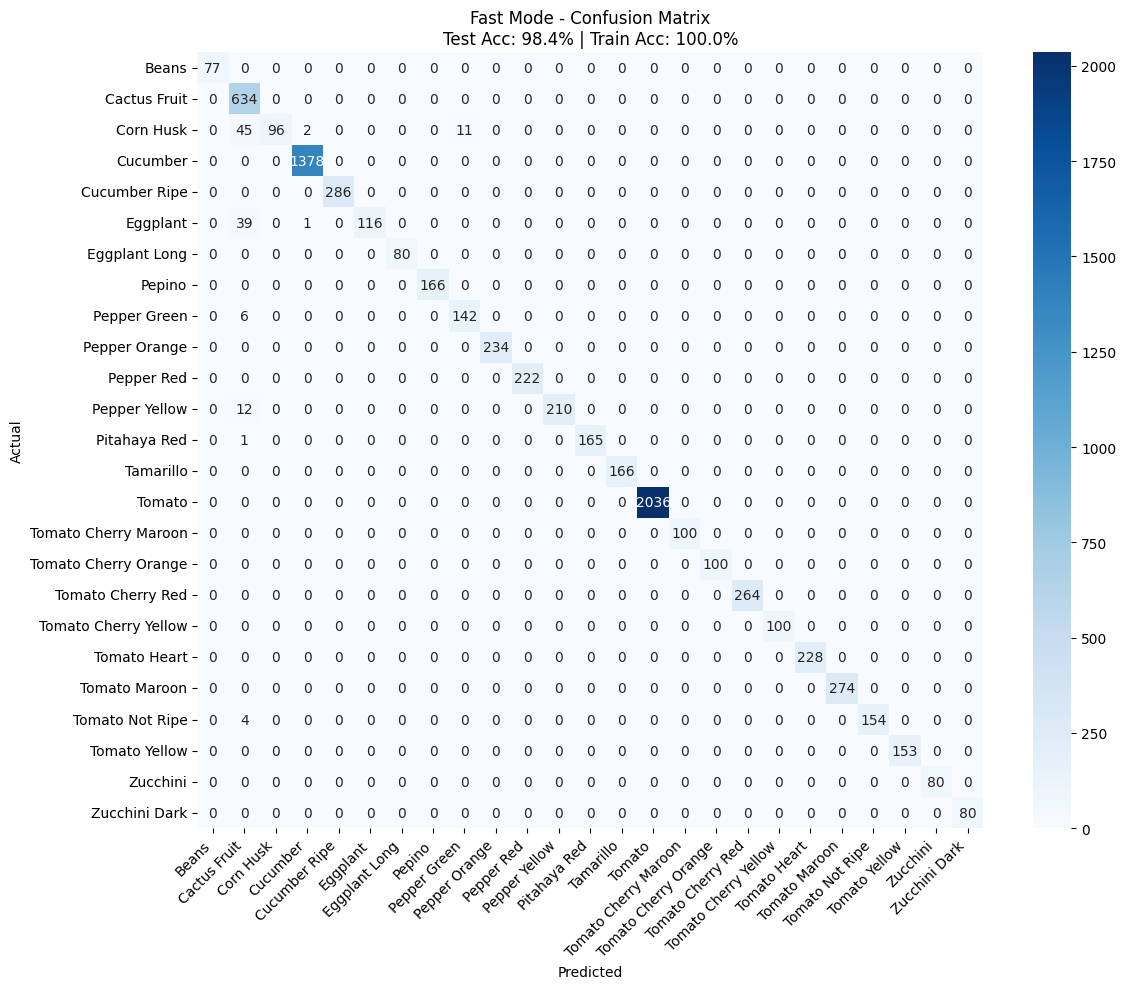


💾 Saving Fast Model...
✅ Fast model saved!


In [ ]:
# ============ TRAIN FAST MODEL ============
print("\n\n🚀 PHASE 1: FAST MODEL")

X_train_fast, y_train_fast = load_dataset(
    DATASET_PATH, 'Training', extract_features_fast, 'fast'
)
X_test_fast, y_test_fast = load_dataset(
    DATASET_PATH, 'Test', extract_features_fast, 'fast'
)

if len(X_train_fast) > 0 and len(X_test_fast) > 0:
    svm_fast, scaler_fast, le_fast, train_acc_fast, test_acc_fast = train_model(
        X_train_fast, y_train_fast, X_test_fast, y_test_fast, 'fast'
    )

    # Save Fast Model
    print("\n💾 Saving Fast Model...")
    joblib.dump(svm_fast, os.path.join(ARTIFACTS_PATH, 'svm_fast_model.pkl'))
    joblib.dump(scaler_fast, os.path.join(ARTIFACTS_PATH, 'scaler_fast.pkl'))
    joblib.dump(le_fast, os.path.join(ARTIFACTS_PATH, 'label_encoder_fast.pkl'))
    print("✅ Fast model saved!")
else:
    print("❌ Fast model training skipped - no data")


### TRAIN ACCURATE MODEL



🎯 PHASE 2: ACCURATE MODEL

LOADING ACCURATE - Training
Ditemukan 25 kelas: ['Beans', 'Cactus Fruit', 'Corn Husk', 'Cucumber', 'Cucumber Ripe', 'Eggplant', 'Eggplant Long', 'Pepino', 'Pepper Green', 'Pepper Orange', 'Pepper Red', 'Pepper Yellow', 'Pitahaya Red', 'Tamarillo', 'Tomato', 'Tomato Cherry Maroon', 'Tomato Cherry Orange', 'Tomato Cherry Red', 'Tomato Cherry Yellow', 'Tomato Heart', 'Tomato Maroon', 'Tomato Not Ripe', 'Tomato Yellow', 'Zucchini', 'Zucchini Dark']


Training: 100%|██████████| 25/25 [30:50<00:00, 74.04s/it]


✅ Berhasil: 23010 | ❌ Gagal: 0
Dimensi fitur: (23010, 1420)

LOADING ACCURATE - Test
Ditemukan 25 kelas: ['Beans', 'Cactus Fruit', 'Corn Husk', 'Cucumber', 'Cucumber Ripe', 'Eggplant', 'Eggplant Long', 'Pepino', 'Pepper Green', 'Pepper Orange', 'Pepper Red', 'Pepper Yellow', 'Pitahaya Red', 'Tamarillo', 'Tomato', 'Tomato Cherry Maroon', 'Tomato Cherry Orange', 'Tomato Cherry Red', 'Tomato Cherry Yellow', 'Tomato Heart', 'Tomato Maroon', 'Tomato Not Ripe', 'Tomato Yellow', 'Zucchini', 'Zucchini Dark']


Test: 100%|██████████| 25/25 [10:11<00:00, 24.46s/it]


✅ Berhasil: 7662 | ❌ Gagal: 0
Dimensi fitur: (7662, 1420)

TRAINING ACCURATE MODEL
Classes: ['Beans' 'Cactus Fruit' 'Corn Husk' 'Cucumber' 'Cucumber Ripe' 'Eggplant'
 'Eggplant Long' 'Pepino' 'Pepper Green' 'Pepper Orange' 'Pepper Red'
 'Pepper Yellow' 'Pitahaya Red' 'Tamarillo' 'Tomato'
 'Tomato Cherry Maroon' 'Tomato Cherry Orange' 'Tomato Cherry Red'
 'Tomato Cherry Yellow' 'Tomato Heart' 'Tomato Maroon' 'Tomato Not Ripe'
 'Tomato Yellow' 'Zucchini' 'Zucchini Dark']
Training SVM...

📊 Results:
  Train Accuracy: 81.58%
  Test Accuracy: 81.44%
  Overfitting Gap: 0.14%

                      precision    recall  f1-score   support

               Beans       1.00      0.99      0.99        77
        Cactus Fruit       0.96      0.97      0.97       634
           Corn Husk       1.00      0.66      0.79       154
            Cucumber       0.95      0.95      0.95      1378
       Cucumber Ripe       1.00      0.73      0.84       286
            Eggplant       1.00      0.80      0.8

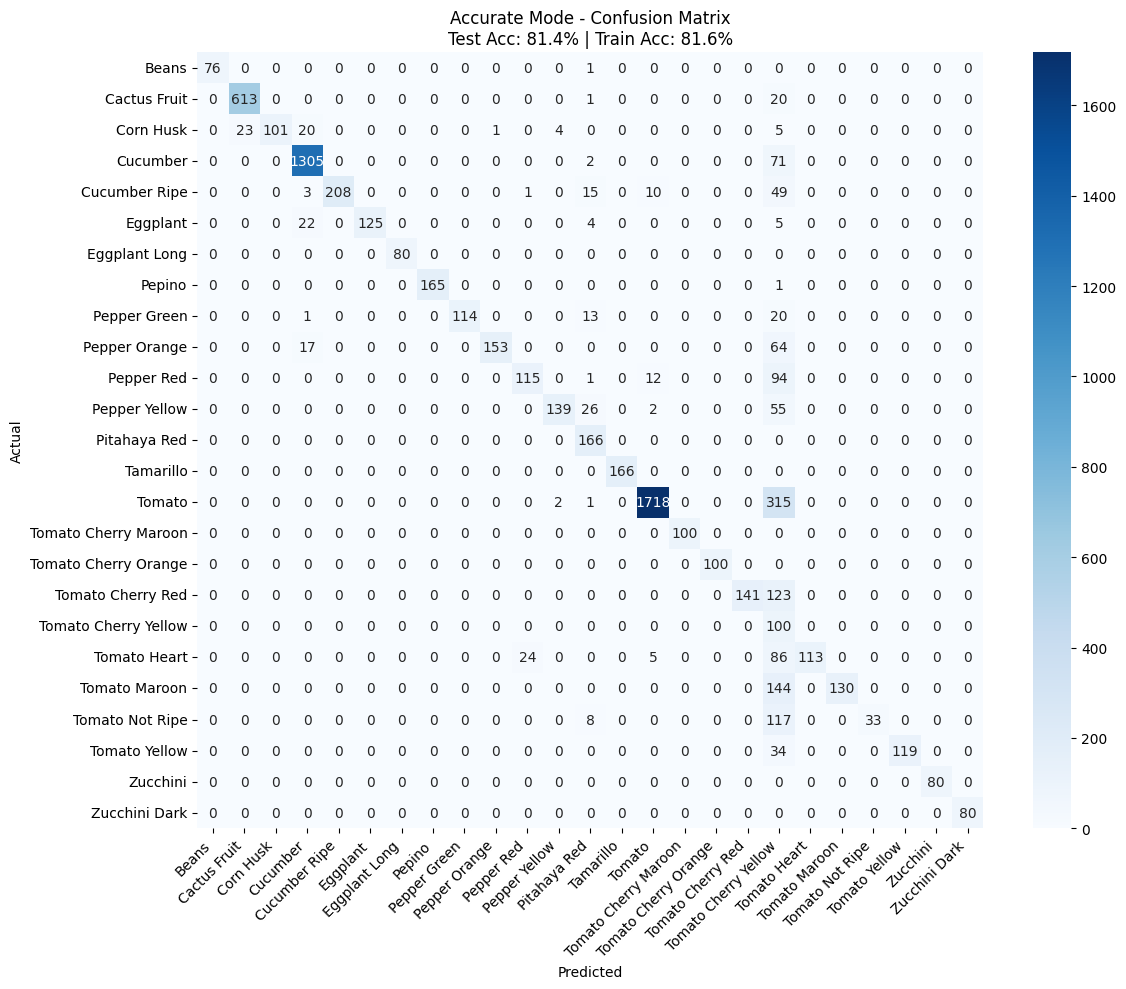


💾 Saving Accurate Model...
✅ Accurate model saved!


In [19]:
# ============ TRAIN ACCURATE MODEL ============
print("\n\n🎯 PHASE 2: ACCURATE MODEL")

X_train_acc, y_train_acc = load_dataset(
    DATASET_PATH, 'Training', extract_features_accurate, 'accurate'
)
X_test_acc, y_test_acc = load_dataset(
    DATASET_PATH, 'Test', extract_features_accurate, 'accurate'
)

if len(X_train_acc) > 0 and len(X_test_acc) > 0:
    svm_acc, scaler_acc, le_acc, train_acc_acc, test_acc_acc = train_model(
        X_train_acc, y_train_acc, X_test_acc, y_test_acc, 'accurate'
    )

    # Save Accurate Model
    print("\n💾 Saving Accurate Model...")
    joblib.dump(svm_acc, os.path.join(ARTIFACTS_PATH, 'svm_accurate_model.pkl'))
    joblib.dump(scaler_acc, os.path.join(ARTIFACTS_PATH, 'scaler_accurate.pkl'))
    joblib.dump(le_acc, os.path.join(ARTIFACTS_PATH, 'label_encoder_accurate.pkl'))
    print("✅ Accurate model saved!")
else:
    print("❌ Accurate model training skipped - no data")

## VISUALIZATION

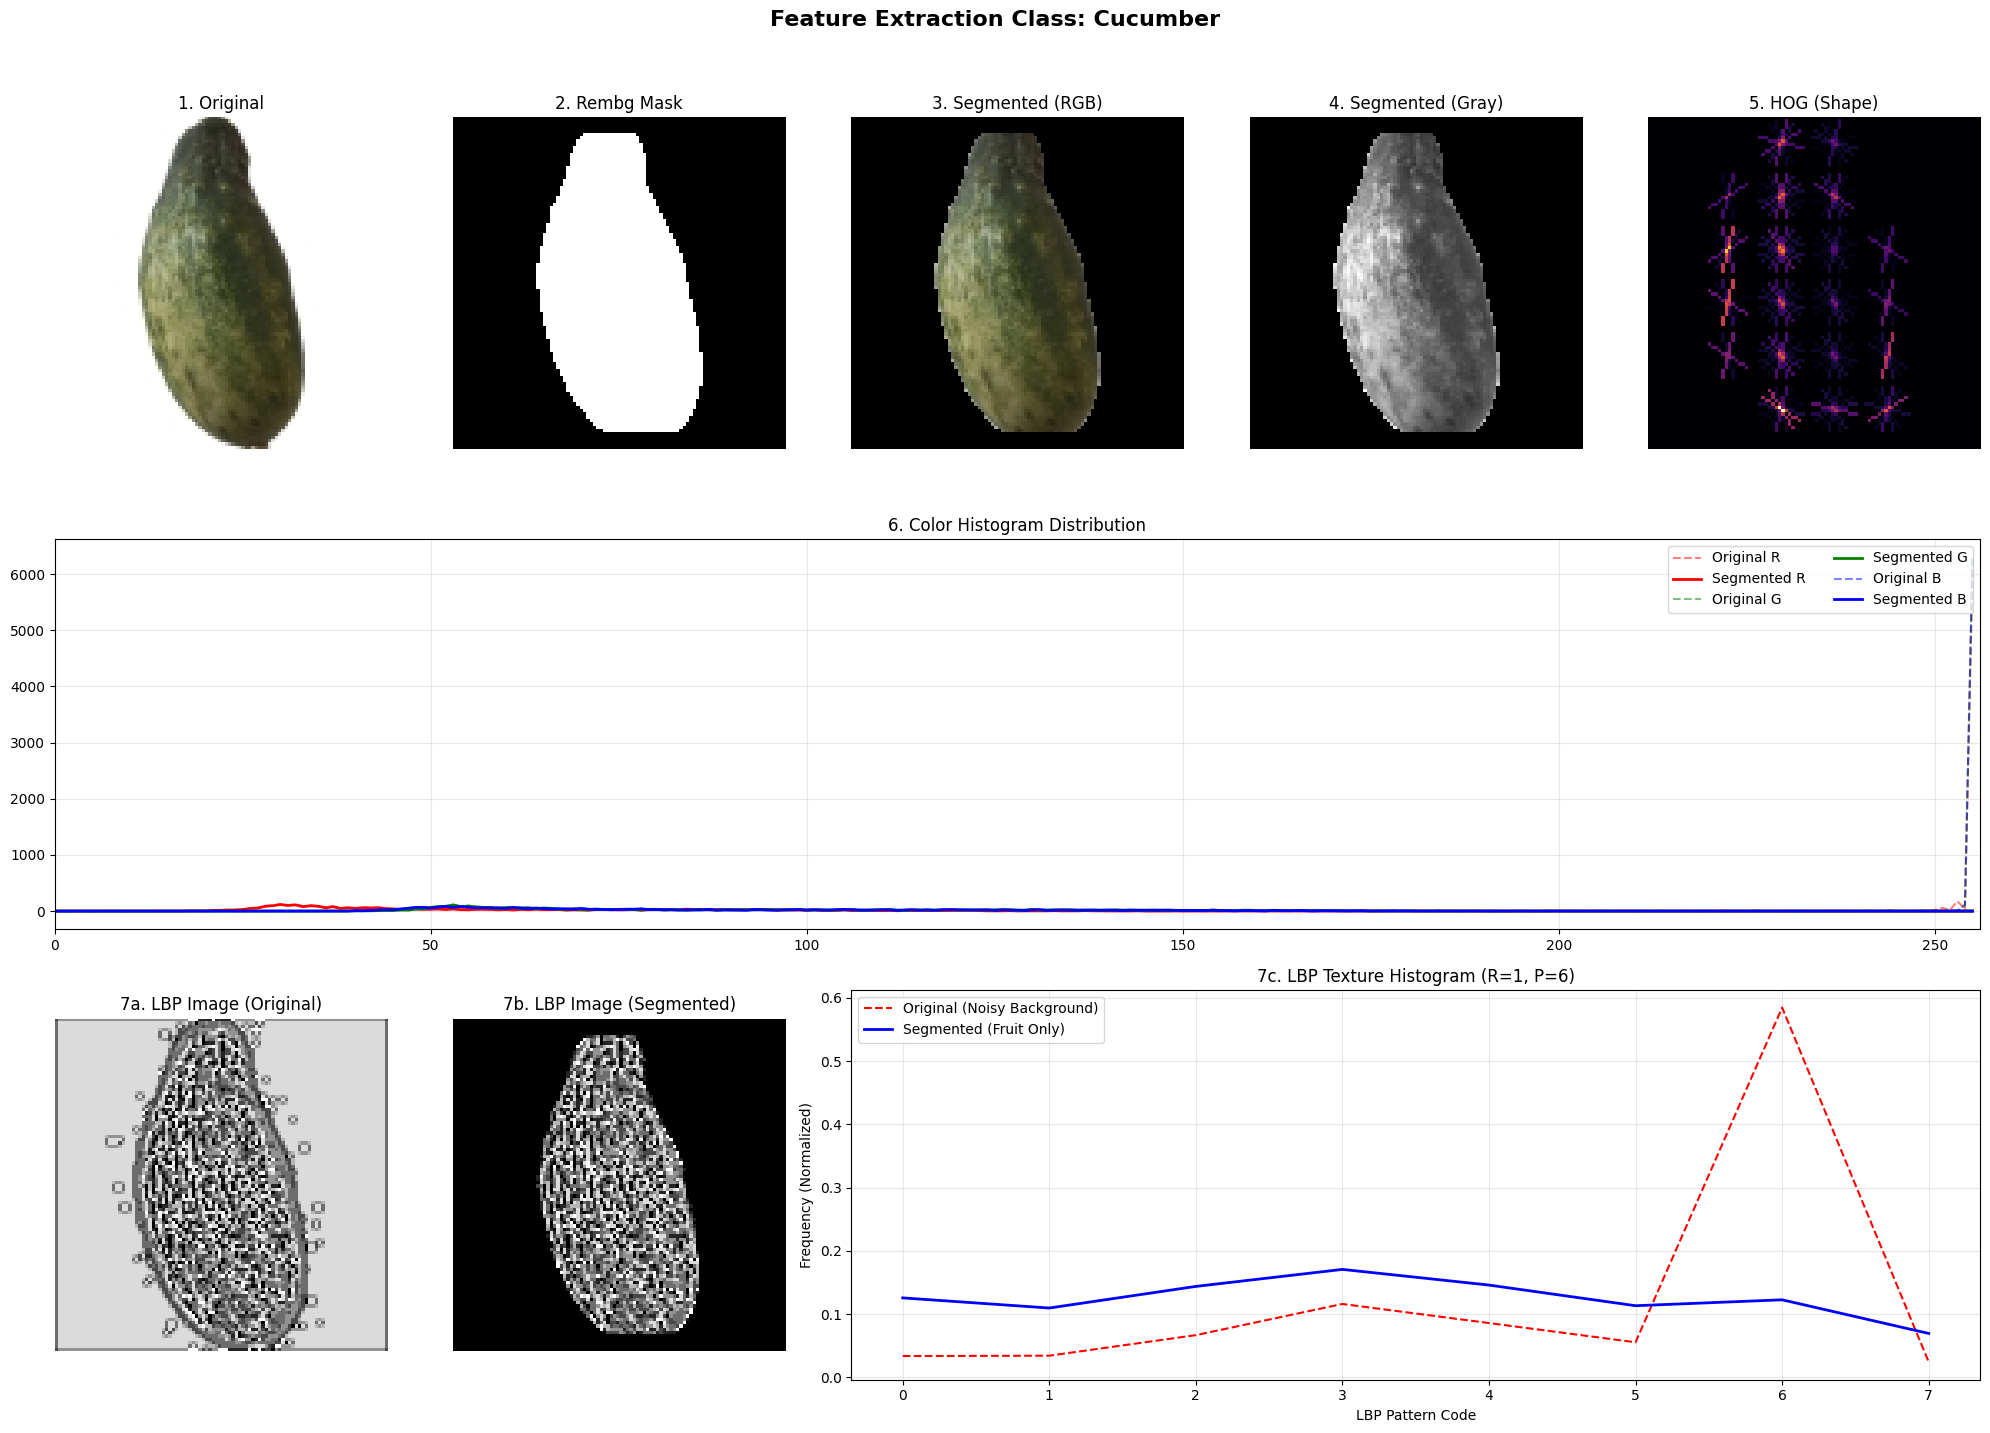

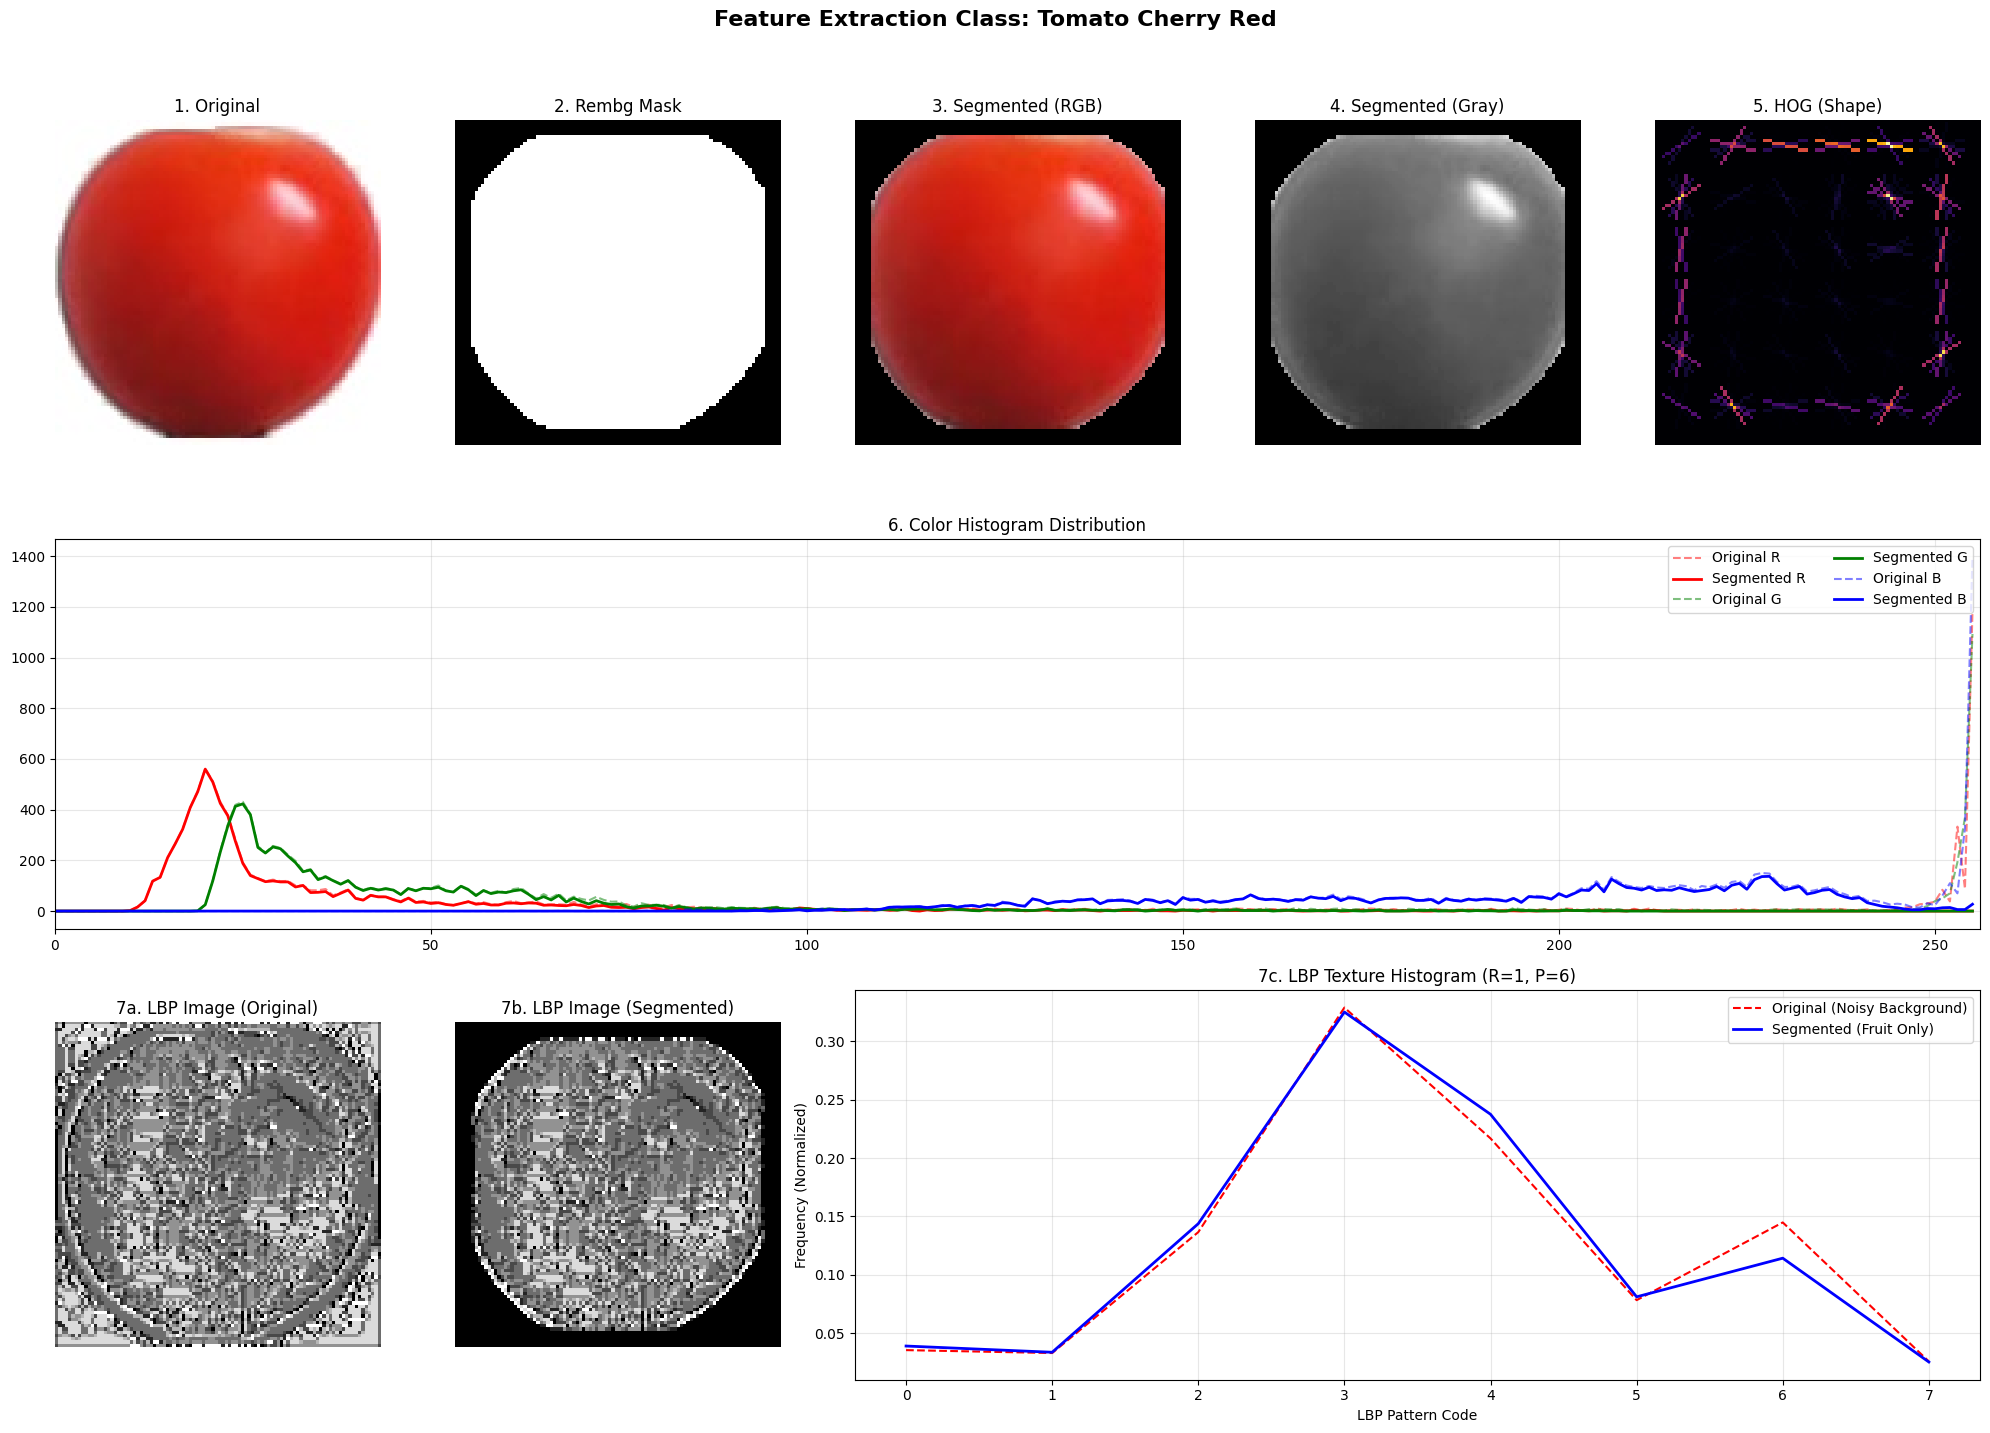

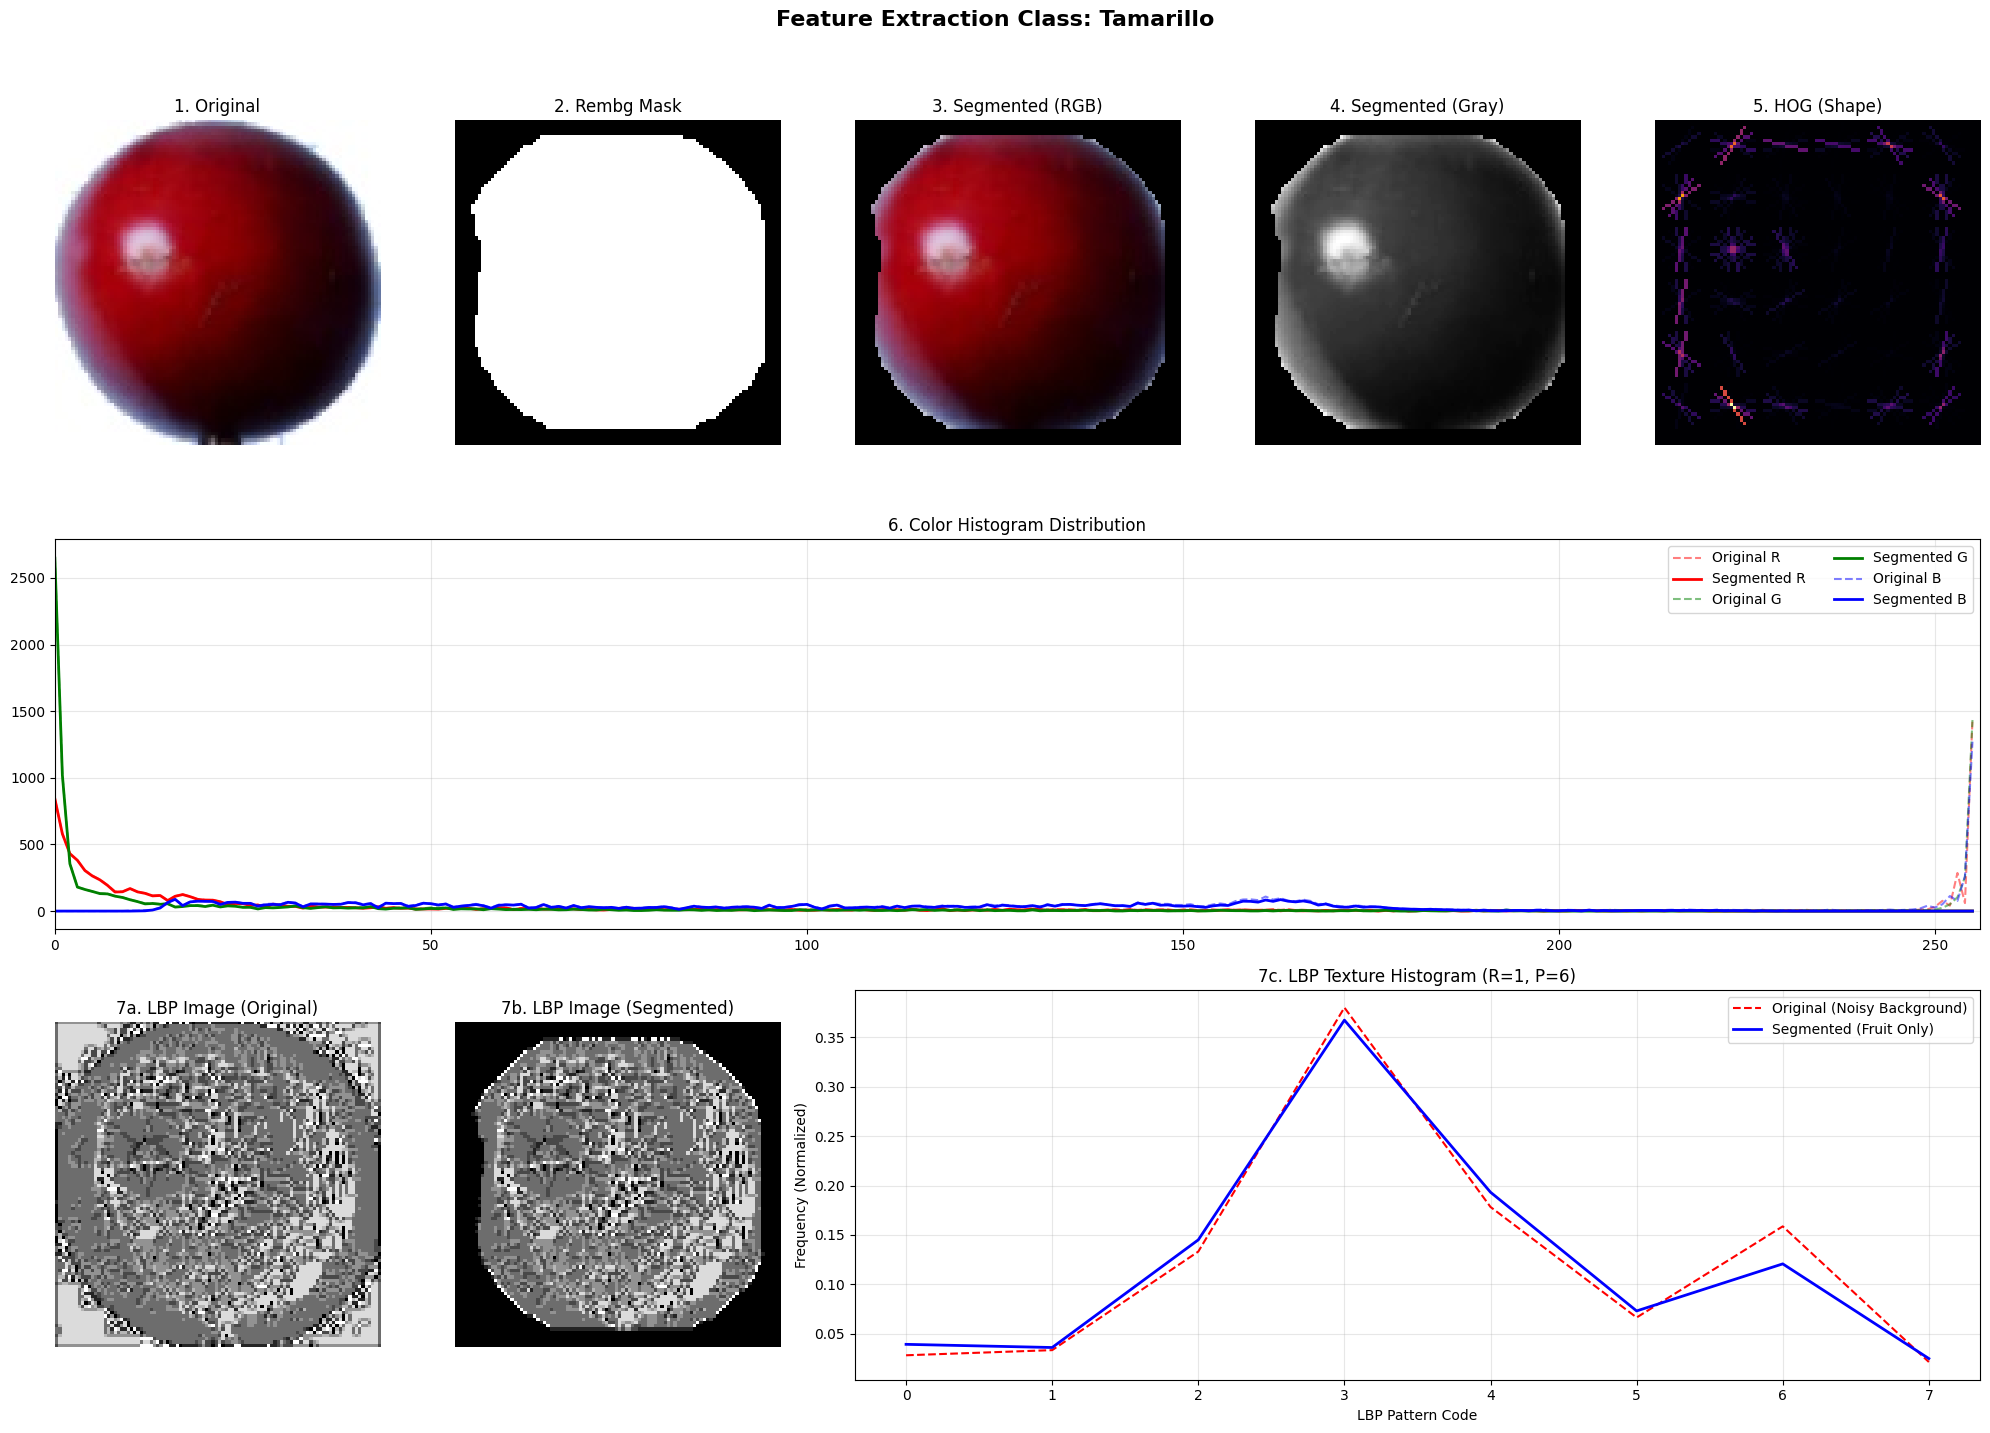

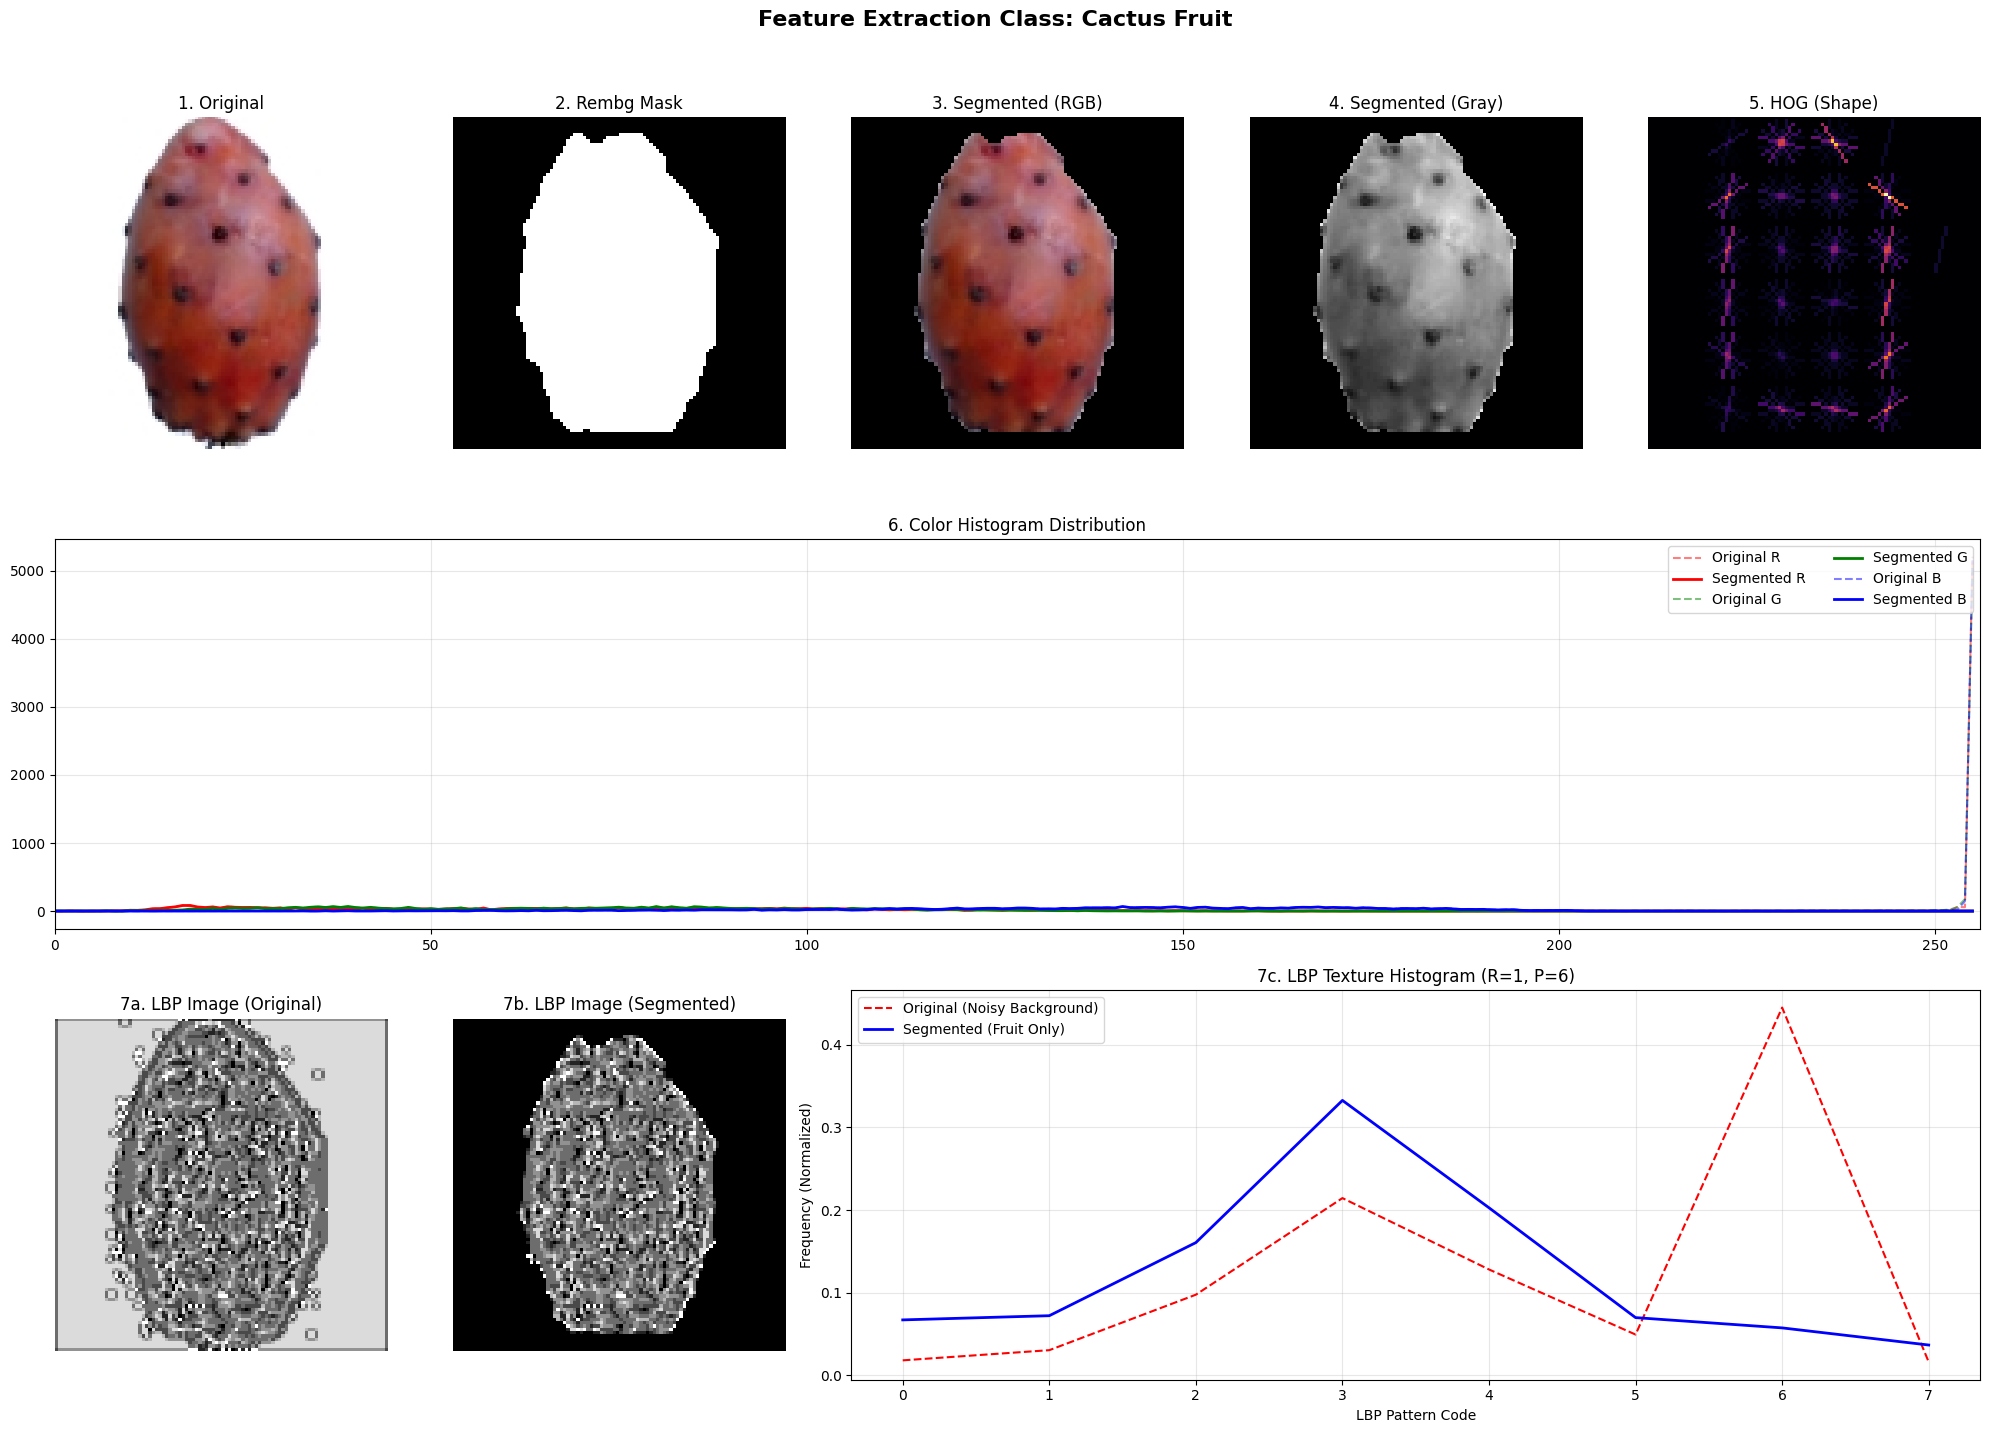

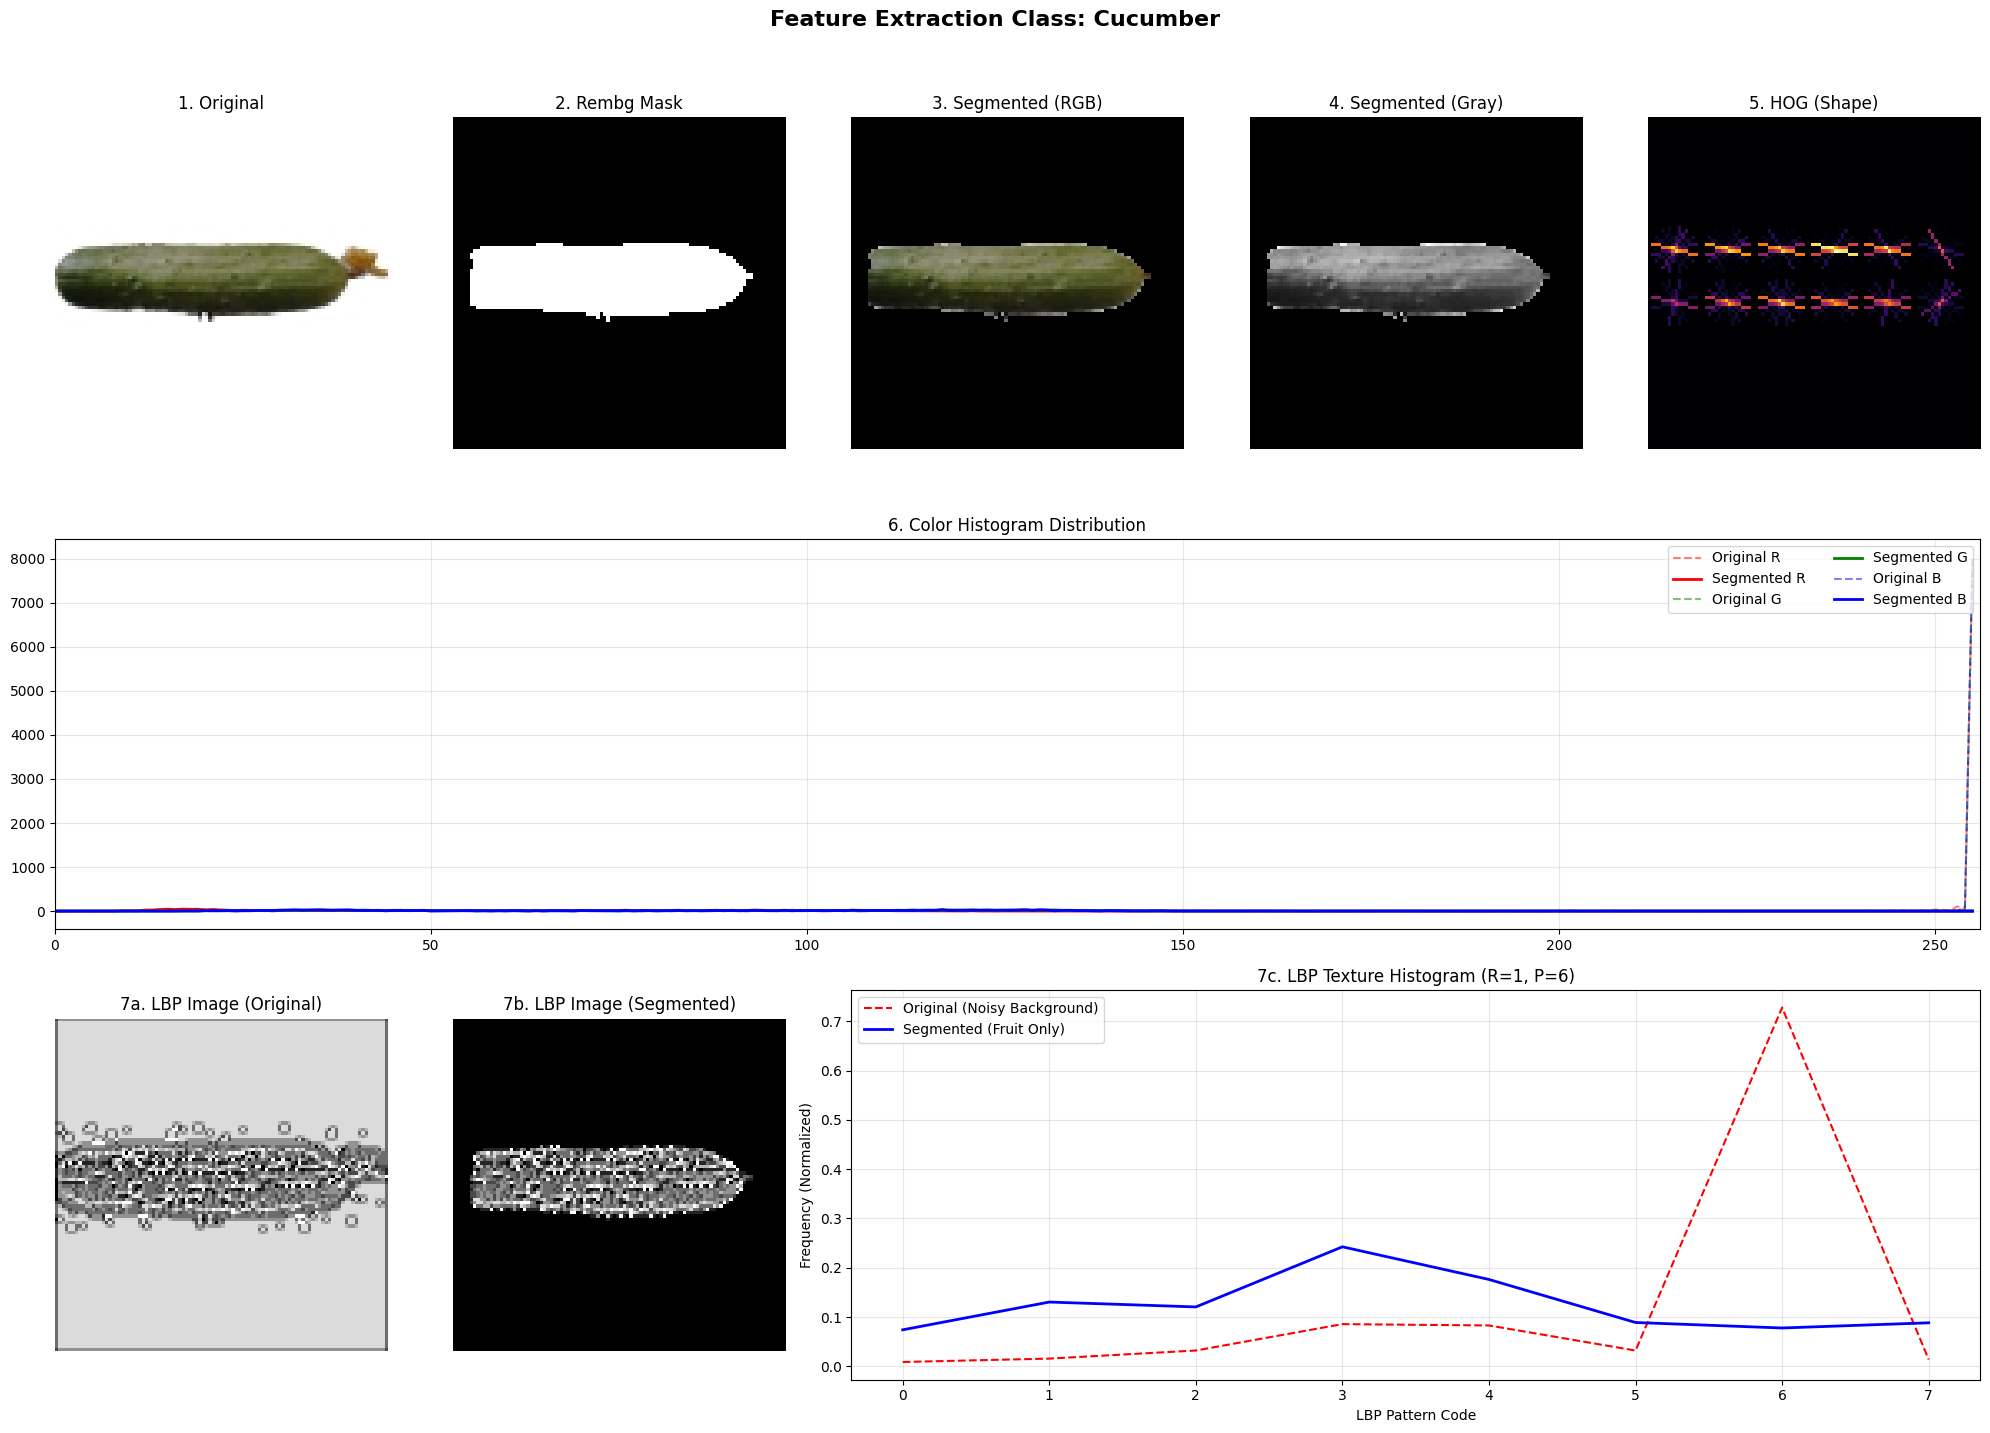

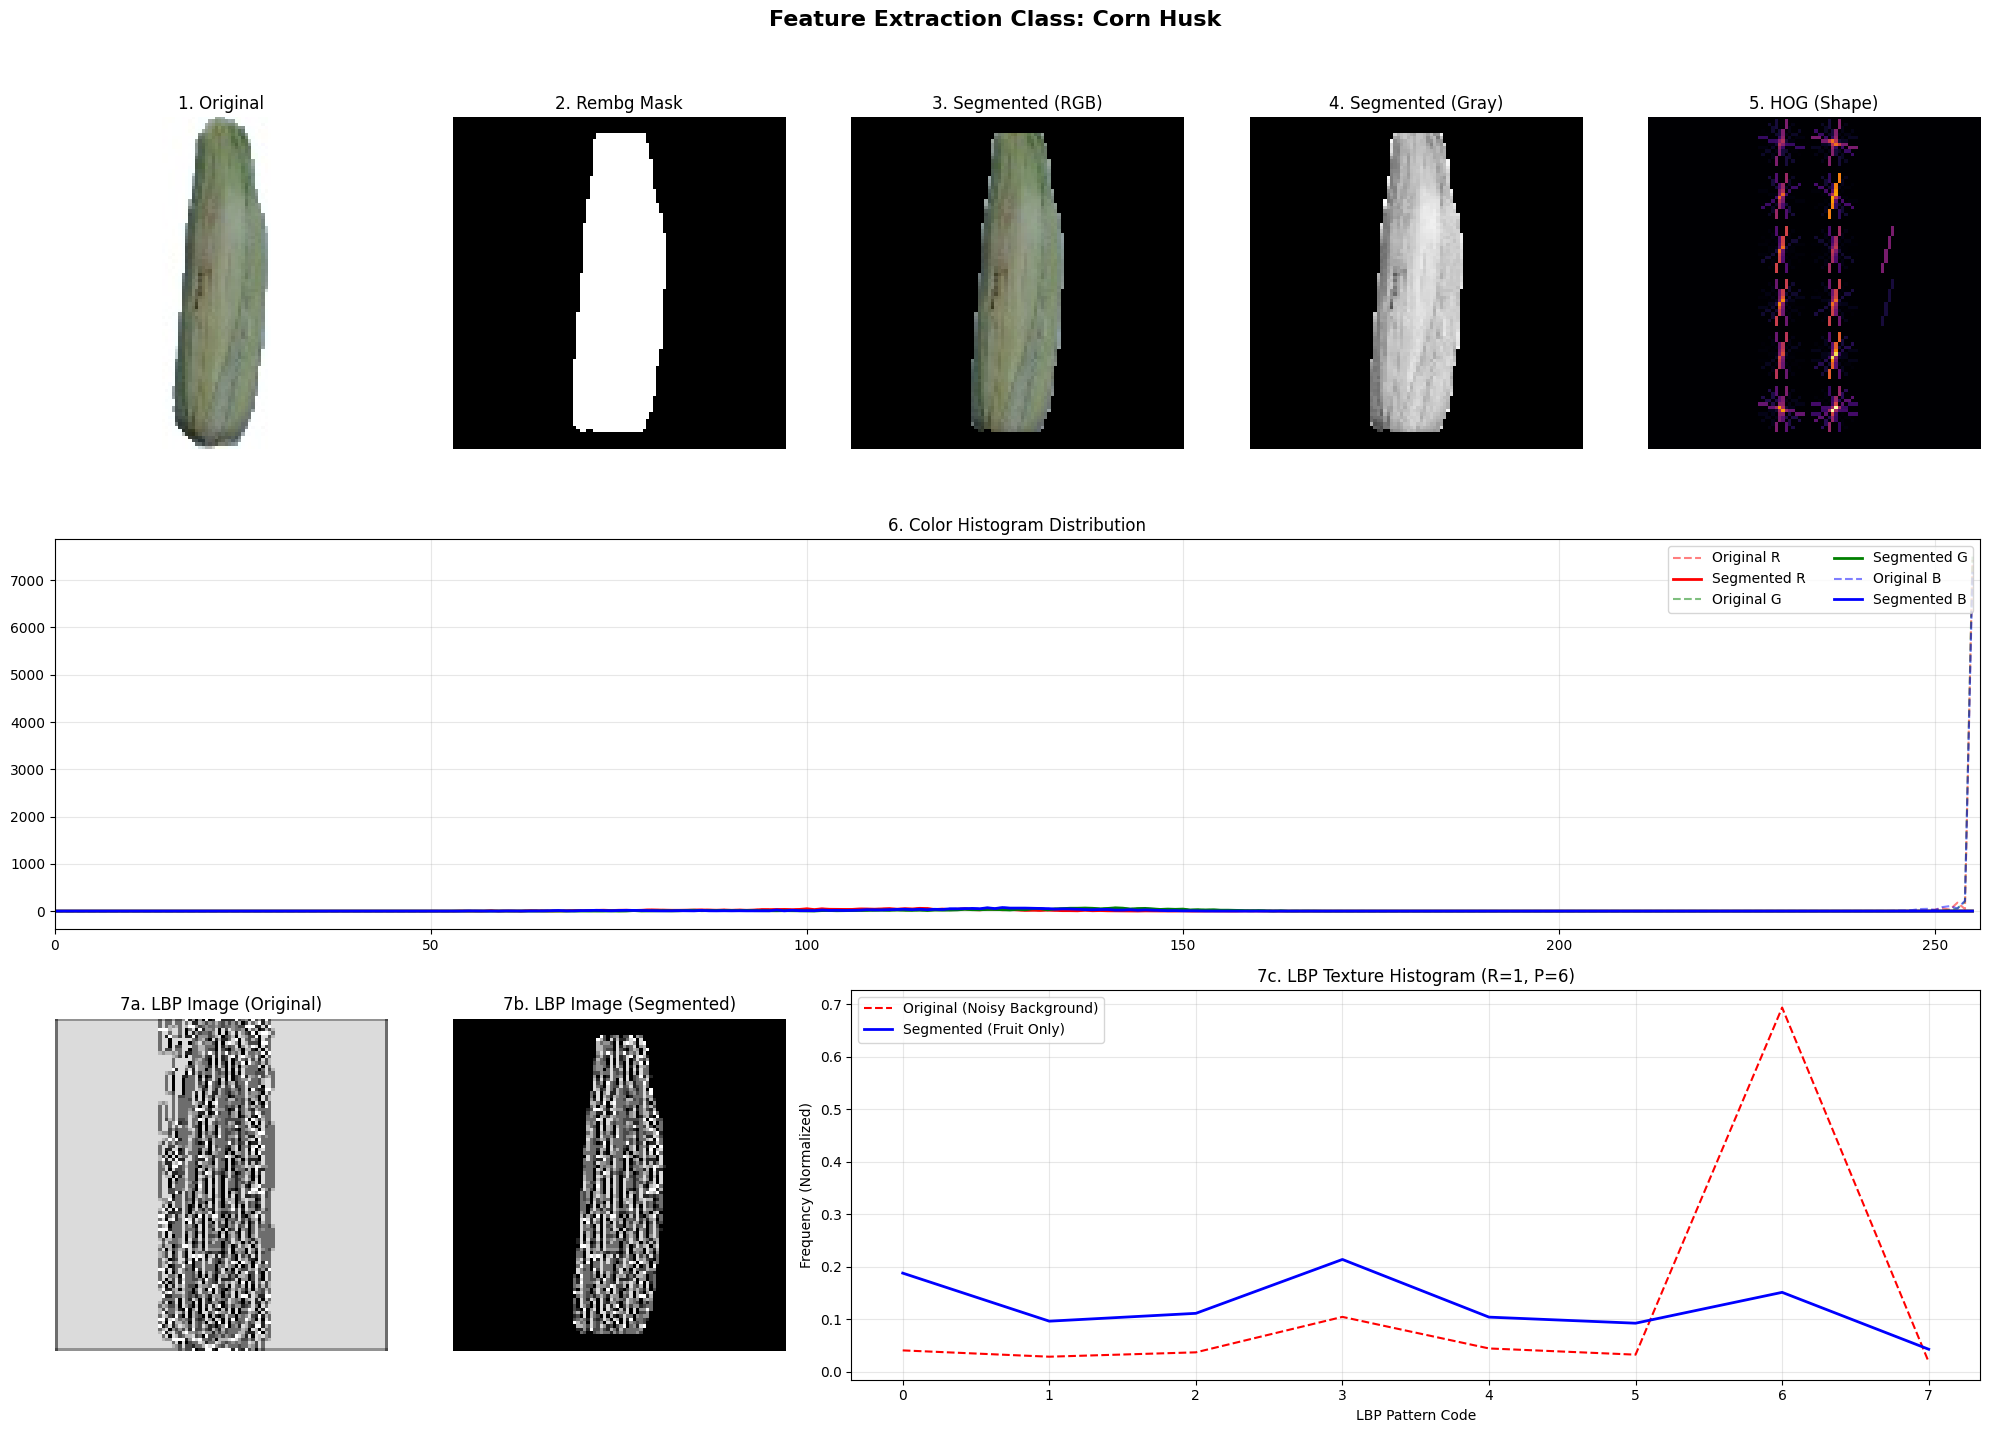

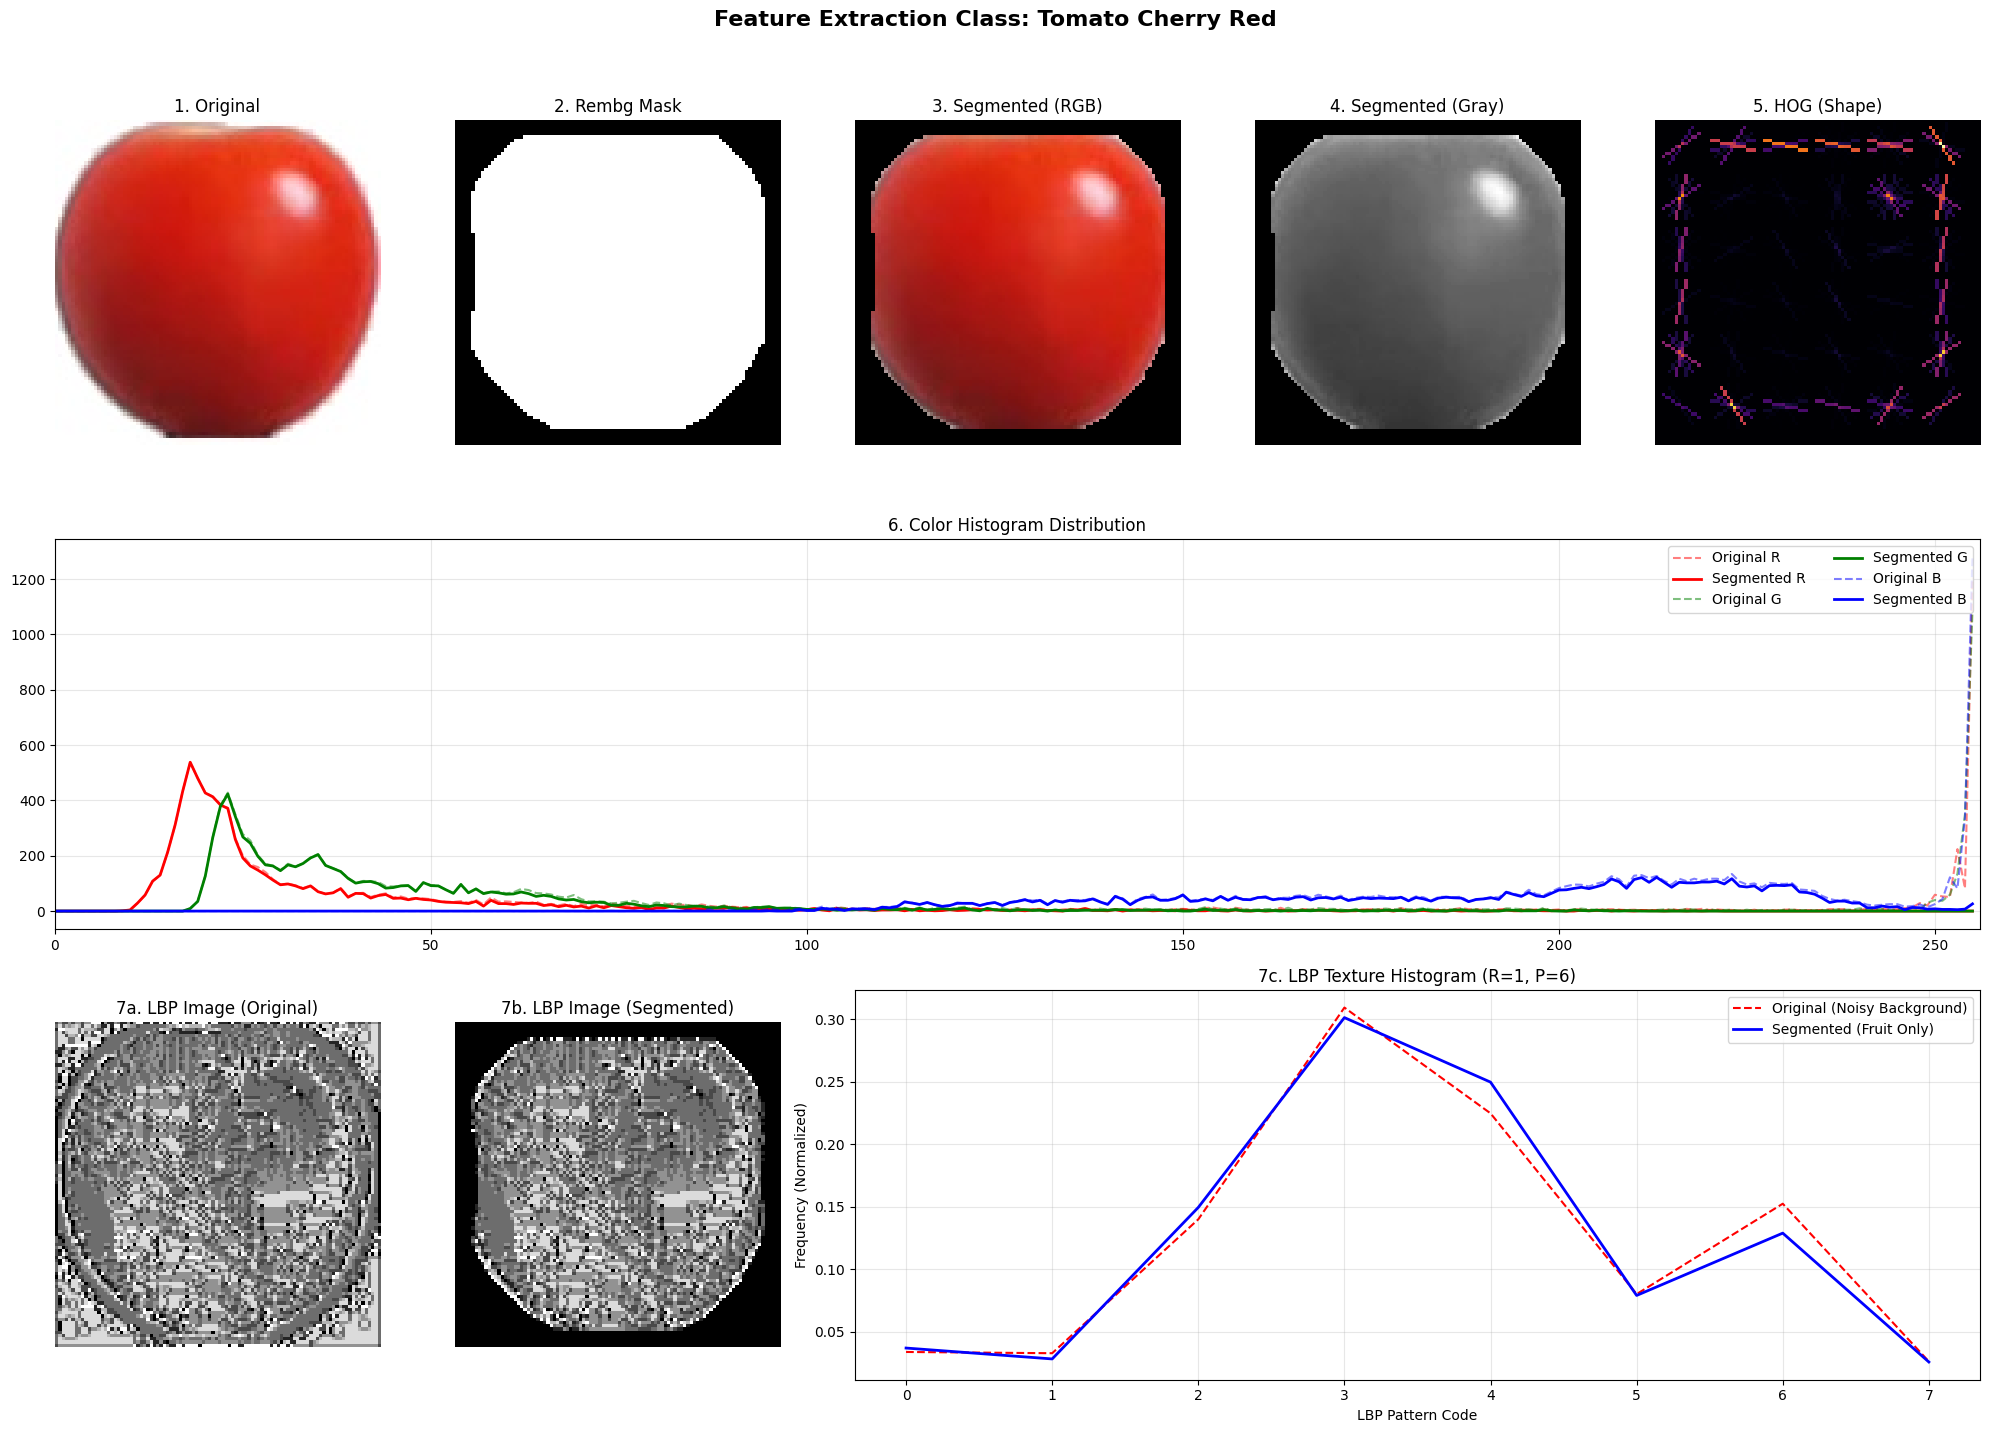

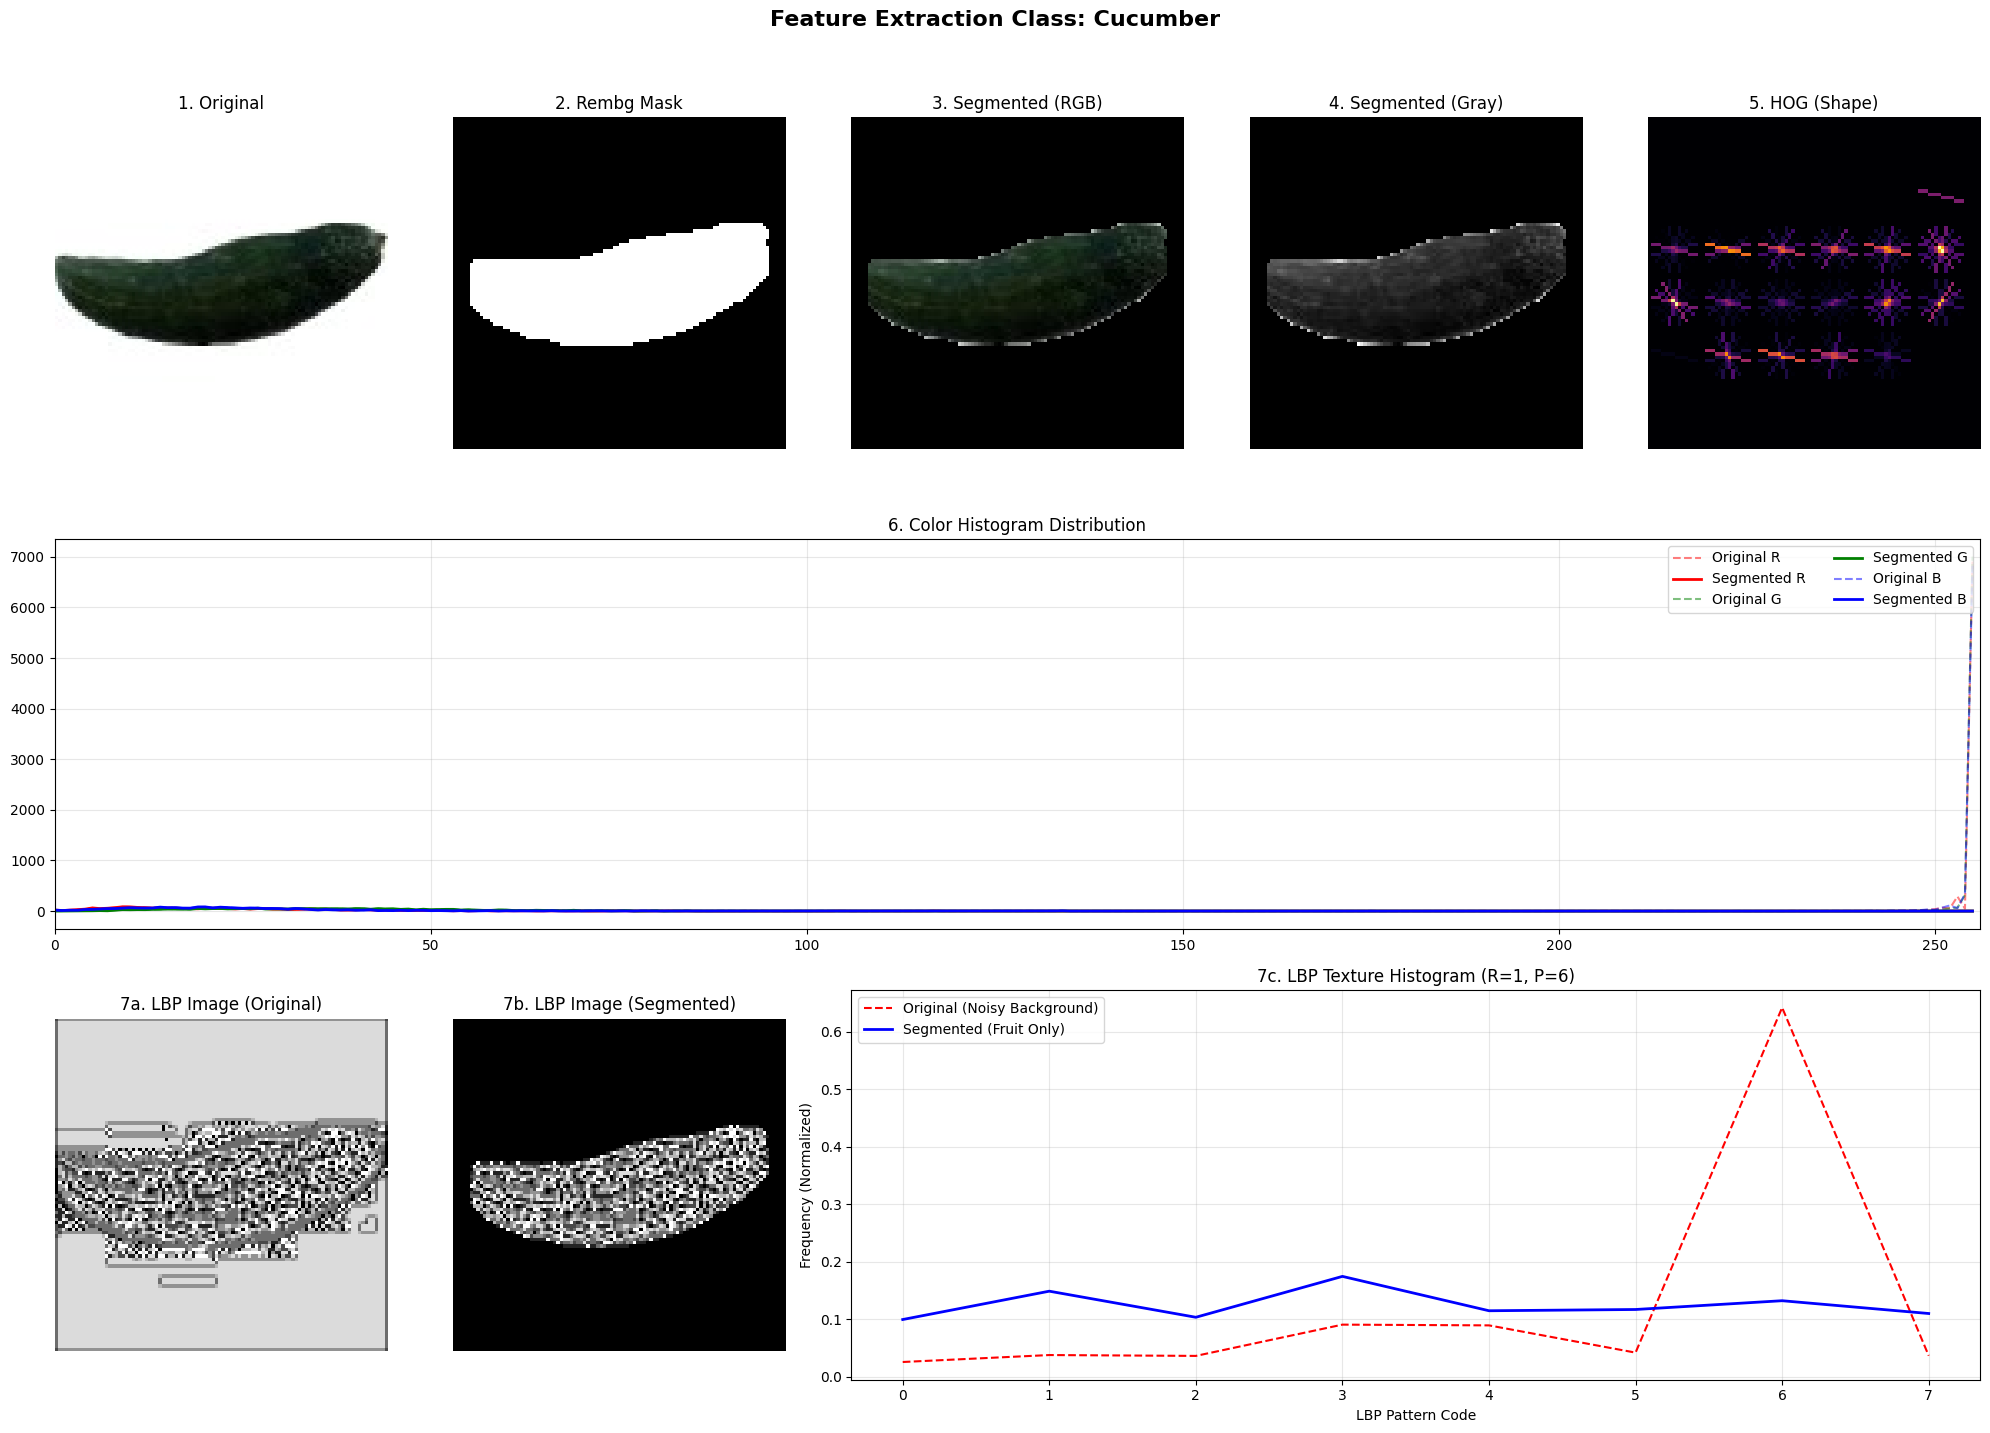

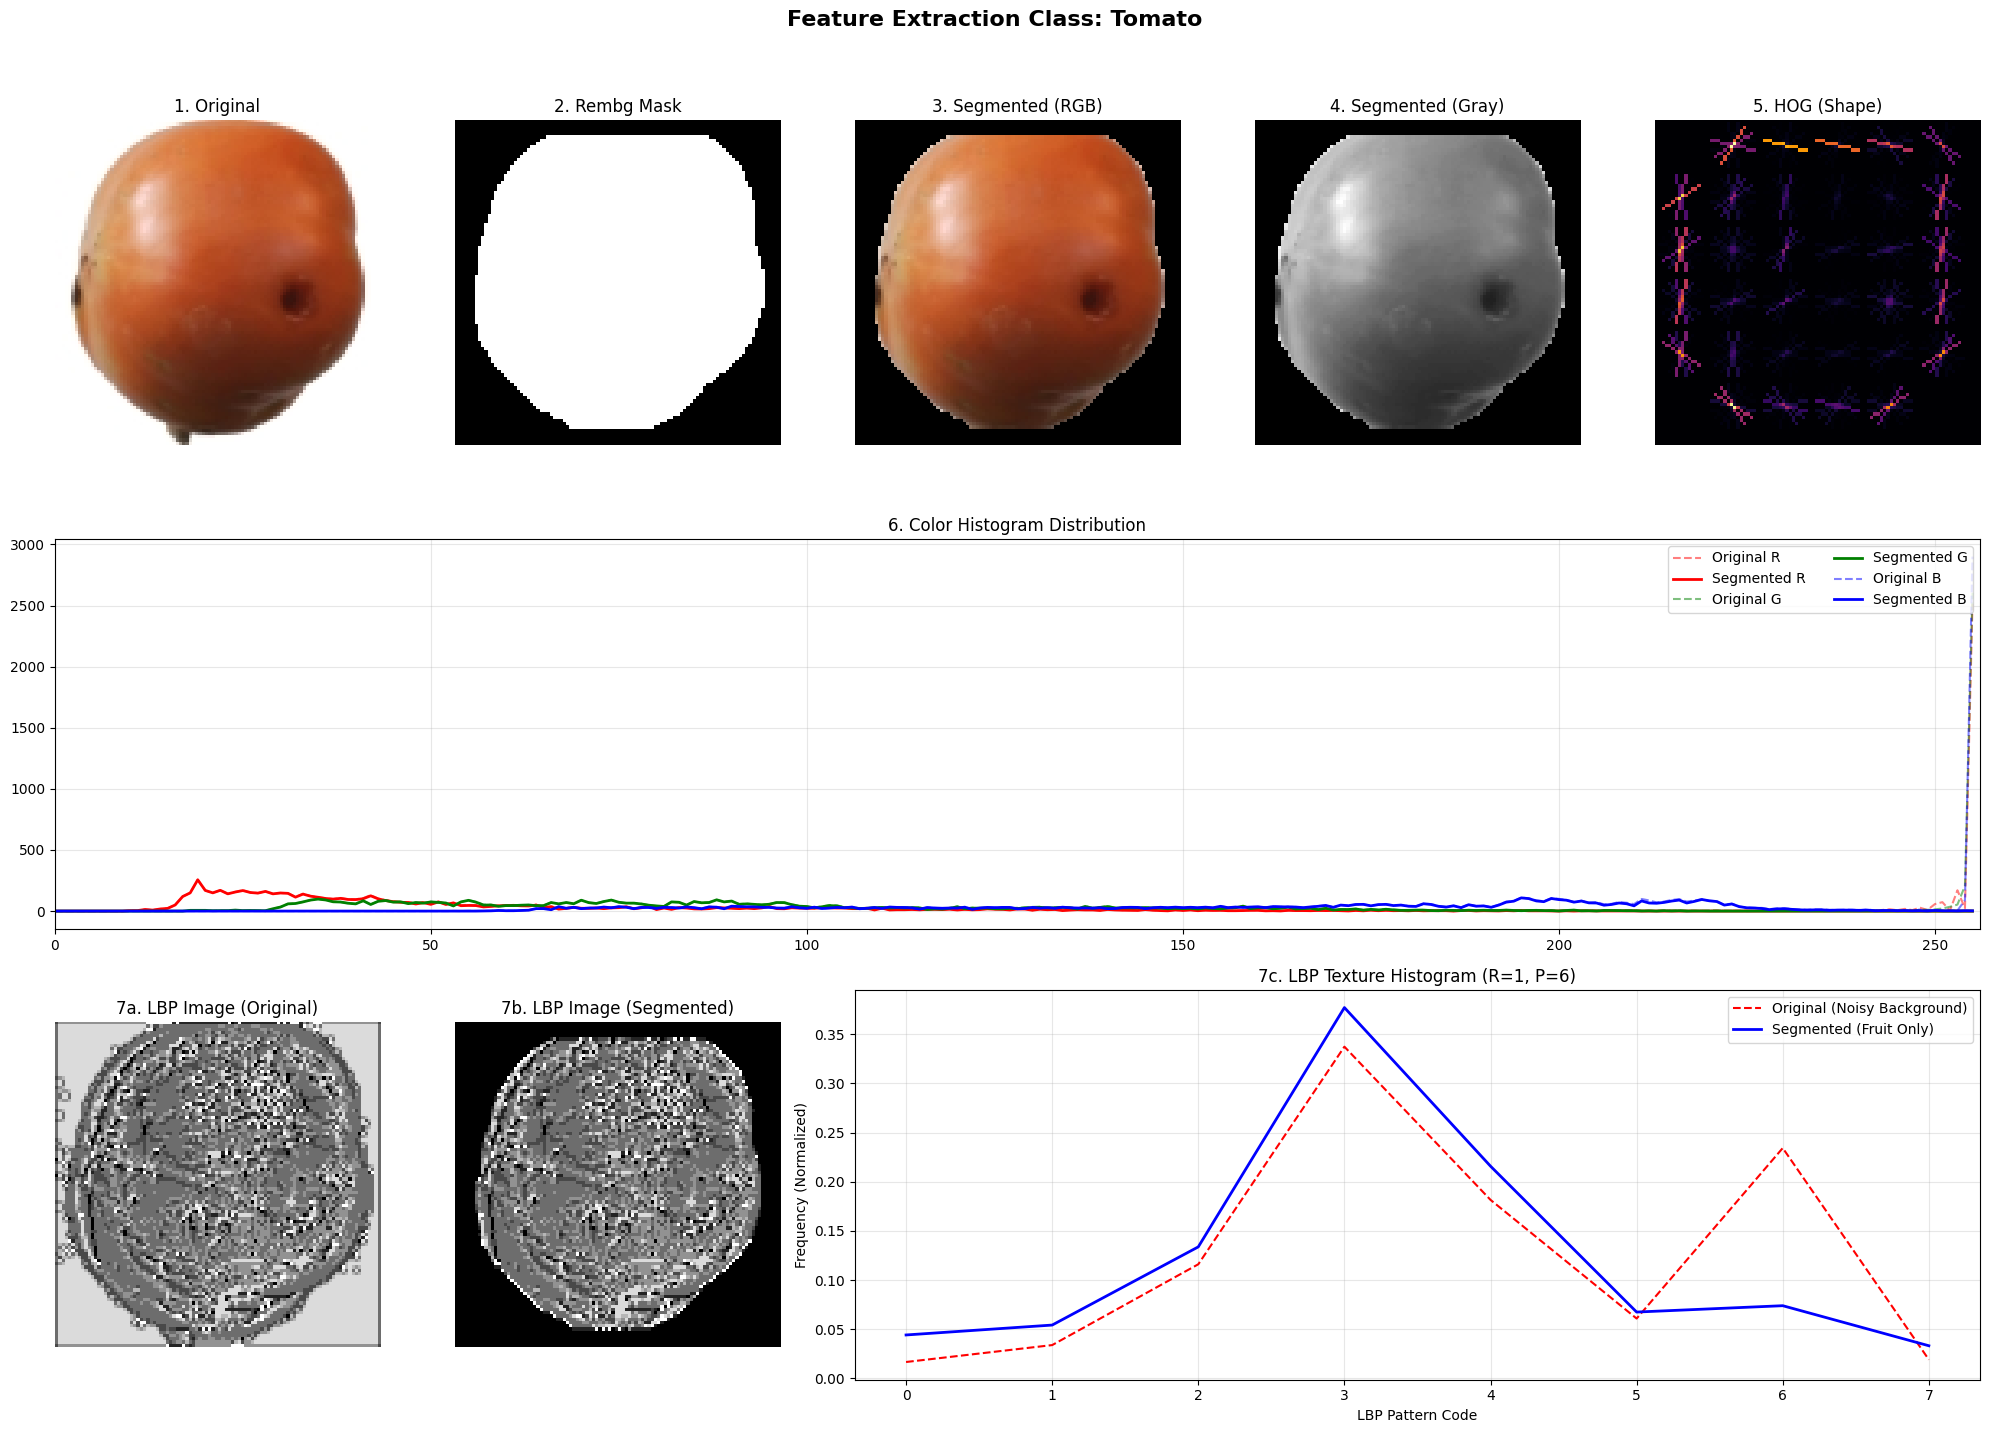

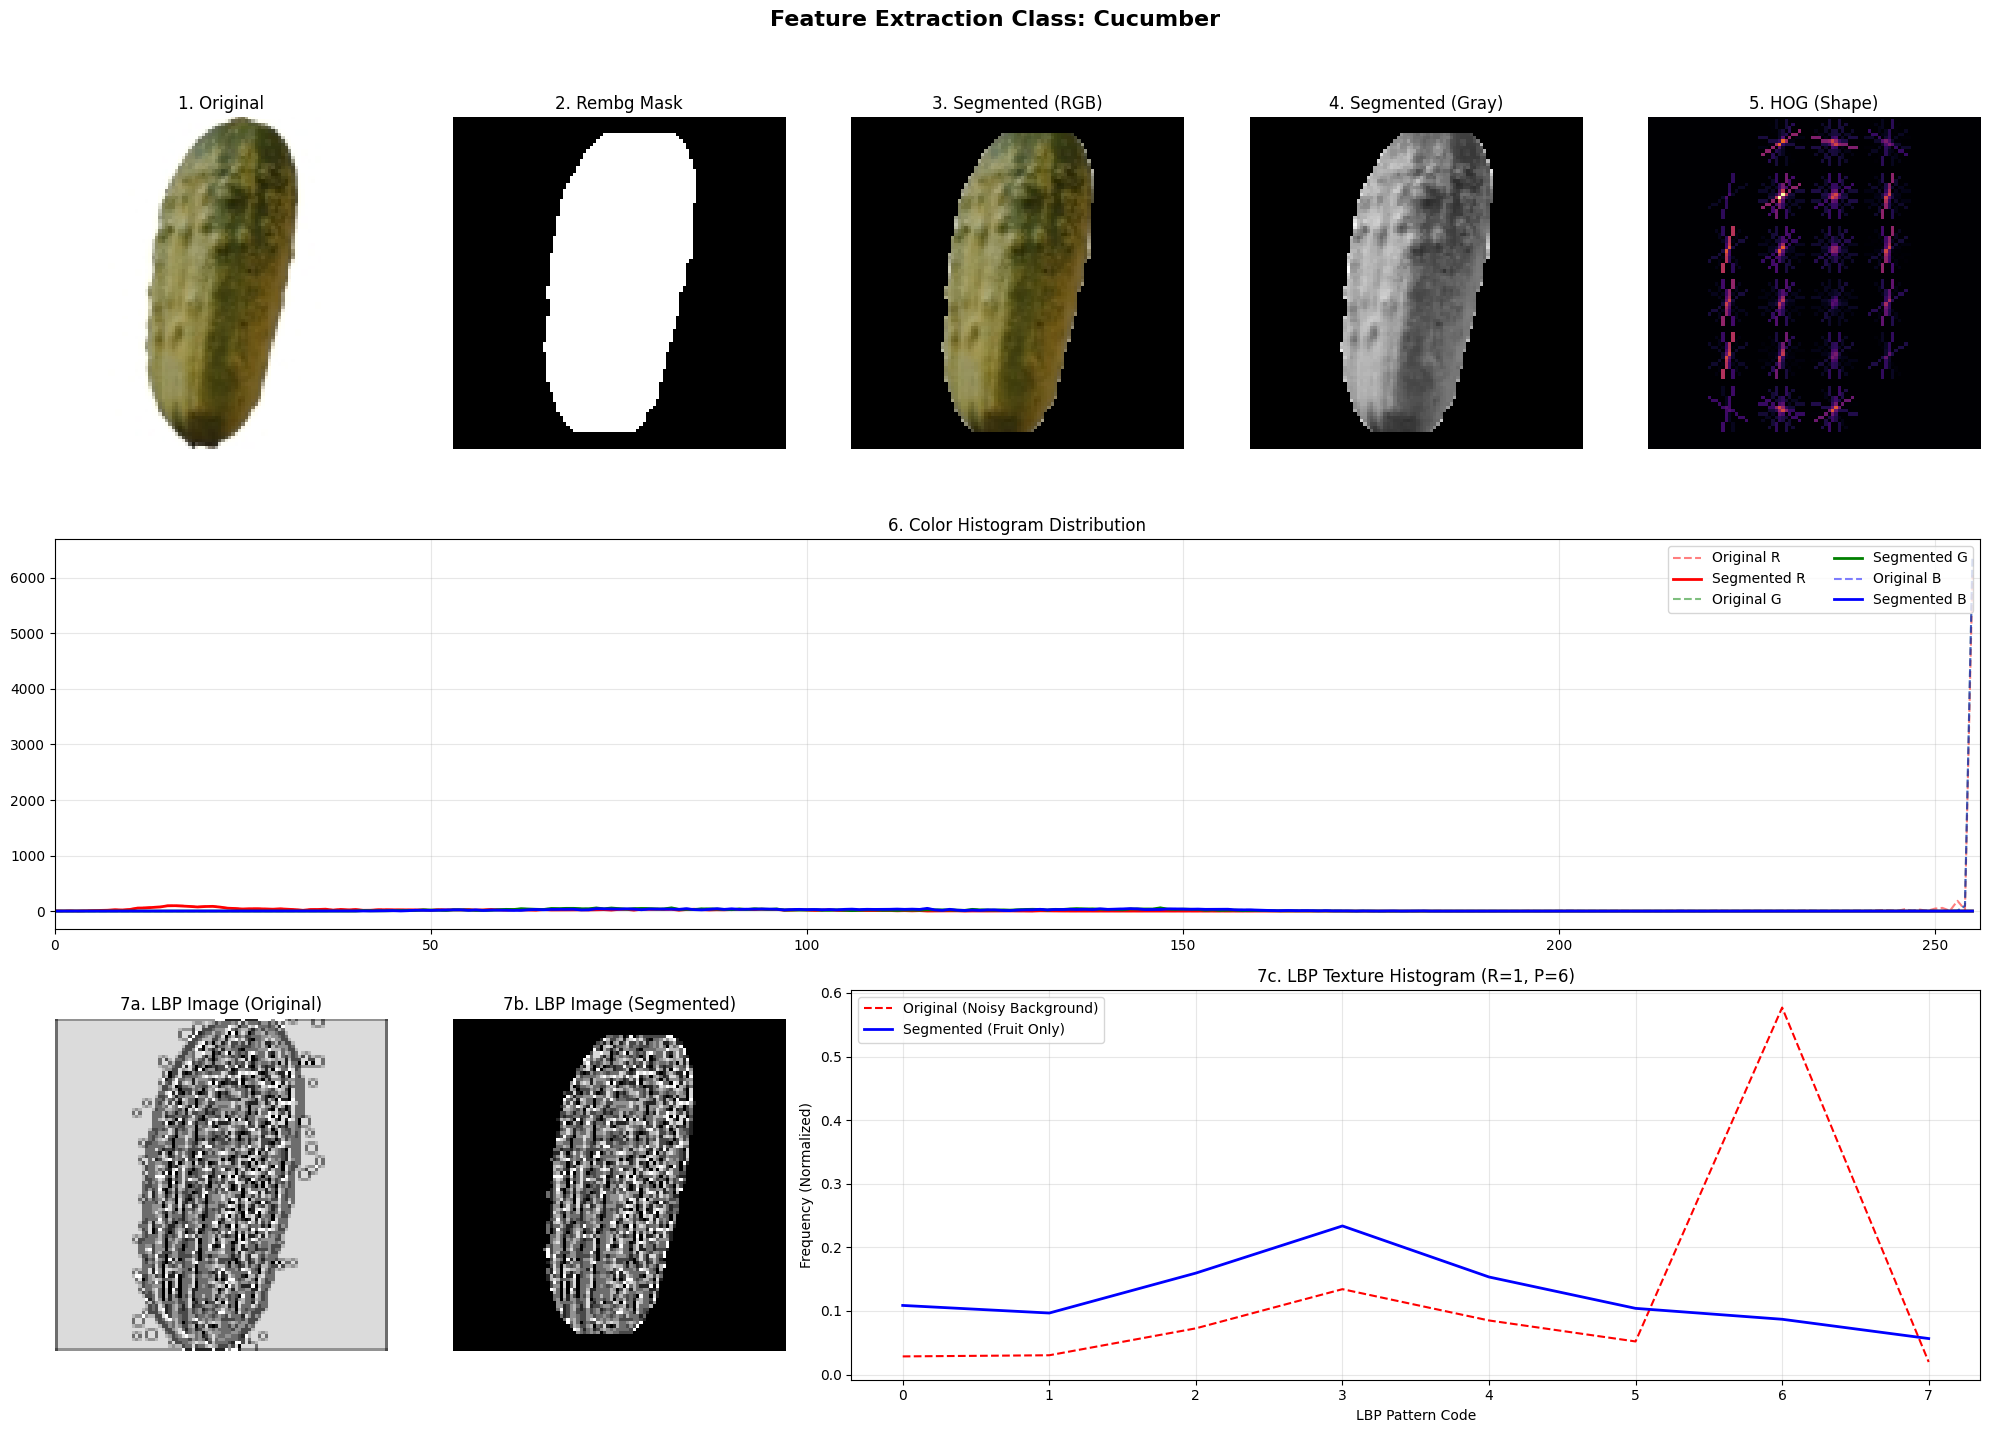

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import random
from skimage.feature import hog, local_binary_pattern

# ==========================================
# CONFIG
# ==========================================
DATASET_ROOT = '/content/fruit-clean/Training'

# ==========================================
# HELPER FUNCTIONS
# ==========================================

def get_accurate_segmentation(img_bgr):
    """
    Accurate segmentation menggunakan GrabCut
    Output:
    - mask (0–255)
    - result_bgr (background hitam)
    """
    try:
        img = img_bgr.copy()
        h, w = img.shape[:2]

        # Inisialisasi mask GrabCut
        mask = np.zeros((h, w), np.uint8)

        # Asumsi objek di tengah (aman untuk dataset buah)
        rect = (5, 5, w - 10, h - 10)

        bgdModel = np.zeros((1, 65), np.float64)
        fgdModel = np.zeros((1, 65), np.float64)

        cv2.grabCut(
            img, mask, rect,
            bgdModel, fgdModel,
            5, cv2.GC_INIT_WITH_RECT
        )

        # Konversi mask GrabCut → binary mask
        mask_binary = np.where(
            (mask == cv2.GC_FGD) | (mask == cv2.GC_PR_FGD),
            255, 0
        ).astype('uint8')

        # Terapkan mask ke gambar
        result_bgr = cv2.bitwise_and(img, img, mask=mask_binary)

        return mask_binary, result_bgr

    except Exception as e:
        # Fallback (sangat jarang terjadi)
        gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
        return mask, img_bgr

def get_hog_vis(img_gray, pixels_per_cell):
    """Mendapatkan visualisasi HOG"""
    fd, hog_image = hog(img_gray, orientations=8, pixels_per_cell=pixels_per_cell,
                        cells_per_block=(2, 2), visualize=True, block_norm="L2-Hys")
    return hog_image

# ==========================================
# MAIN VISUALIZATION PIPELINE
# ==========================================

def visualize_extraction(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Gambar rusak: {image_path}")
        return

    folder_name = image_path.split(os.sep)[-2]
    file_name = image_path.split(os.sep)[-1]

    # --- PROCESSING ---
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (100, 100))
    img_gray_fast = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

    # Accurate Processing (Segmentation menggunakan rembg)
    clean_mask, img_seg = get_accurate_segmentation(img_resized)
    img_seg_rgb = cv2.cvtColor(img_seg, cv2.COLOR_BGR2RGB)
    img_gray_acc = cv2.cvtColor(img_seg, cv2.COLOR_BGR2GRAY)

    # HOG Processing
    hog_acc = get_hog_vis(img_gray_acc, (16, 16))

    # --- LBP PROCESSING ---
    radius = 1
    n_points = 6 * radius
    METHOD = 'uniform'

    # Hitung LBP Image
    lbp_fast = local_binary_pattern(img_gray_fast, n_points, radius, METHOD)
    lbp_acc = local_binary_pattern(img_gray_acc, n_points, radius, METHOD)

    # Hitung Histogram LBP
    n_bins = int(lbp_fast.max() + 1)
    hist_lbp_fast, _ = np.histogram(lbp_fast.ravel(), bins=n_bins, range=(0, n_bins), density=True)

    # Filter background untuk LBP Accurate
    lbp_acc_valid = lbp_acc[clean_mask > 0]  # Hanya ambil pixel dalam mask
    if len(lbp_acc_valid) == 0:
        lbp_acc_valid = lbp_acc.ravel()  # Fallback
    hist_lbp_acc, _ = np.histogram(lbp_acc_valid, bins=n_bins, range=(0, n_bins), density=True)

    # --- PLOTTING ---
    fig = plt.figure(figsize=(20, 14))
    plt.suptitle(f"Feature Extraction Class: {folder_name}",
                 fontsize=16, fontweight='bold', y=1.02)

    # ROW 1: IMAGE PIPELINE
    ax1 = plt.subplot2grid((3, 5), (0, 0))
    ax1.imshow(img_rgb)
    ax1.set_title("1. Original")
    ax1.axis('off')

    ax2 = plt.subplot2grid((3, 5), (0, 1))
    ax2.imshow(clean_mask, cmap='gray')
    ax2.set_title("2. Rembg Mask")
    ax2.axis('off')

    ax3 = plt.subplot2grid((3, 5), (0, 2))
    ax3.imshow(img_seg_rgb)
    ax3.set_title("3. Segmented (RGB)")
    ax3.axis('off')

    ax4 = plt.subplot2grid((3, 5), (0, 3))
    ax4.imshow(img_gray_acc, cmap='gray')
    ax4.set_title("4. Segmented (Gray)")
    ax4.axis('off')

    ax5 = plt.subplot2grid((3, 5), (0, 4))
    ax5.imshow(hog_acc, cmap='inferno')
    ax5.set_title("5. HOG (Shape)")
    ax5.axis('off')

    # ROW 2: COLOR HISTOGRAM
    ax6 = plt.subplot2grid((3, 5), (1, 0), colspan=5)
    colors = ('r', 'g', 'b')
    for i, color in enumerate(colors):
        hist_fast = cv2.calcHist([img_resized], [i], None, [256], [0, 256])
        ax6.plot(hist_fast, color=color, linestyle='--', alpha=0.5,
                label=f'Original {color.upper()}')
        hist_acc = cv2.calcHist([img_seg], [i], clean_mask, [256], [0, 256])
        ax6.plot(hist_acc, color=color, linewidth=2,
                label=f'Segmented {color.upper()}')
    ax6.set_title("6. Color Histogram Distribution")
    ax6.legend(loc='upper right', ncol=2)
    ax6.grid(True, alpha=0.3)
    ax6.set_xlim([0, 256])

    # ROW 3: LBP TEXTURE ANALYSIS
    ax7 = plt.subplot2grid((3, 5), (2, 0), colspan=1)
    ax7.imshow(lbp_fast, cmap='gray')
    ax7.set_title("7a. LBP Image (Original)")
    ax7.axis('off')

    ax8 = plt.subplot2grid((3, 5), (2, 1), colspan=1)
    # Masking visualisasi LBP agar background hitam terlihat hitam
    lbp_vis_masked = cv2.bitwise_and(lbp_acc.astype(np.uint8),
                                     lbp_acc.astype(np.uint8),
                                     mask=clean_mask)
    ax8.imshow(lbp_vis_masked, cmap='gray')
    ax8.set_title("7b. LBP Image (Segmented)")
    ax8.axis('off')

    # LBP Histogram Comparison
    ax9 = plt.subplot2grid((3, 5), (2, 2), colspan=3)
    ax9.plot(hist_lbp_fast, color='red', linestyle='--',
            label='Original (Noisy Background)')
    ax9.plot(hist_lbp_acc, color='blue', linewidth=2,
            label='Segmented (Fruit Only)')
    ax9.set_title(f"7c. LBP Texture Histogram (R={radius}, P={n_points})")
    ax9.set_xlabel("LBP Pattern Code")
    ax9.set_ylabel("Frequency (Normalized)")
    ax9.legend()
    ax9.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# ==========================================
# EXECUTION
# ==========================================
def run_random_visualization(root_path, num_samples=3):
    all_images = []
    for root, dirs, files in os.walk(root_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                all_images.append(os.path.join(root, file))

    if not all_images:
        print("Dataset not found.")
        return

    selected = random.sample(all_images, min(len(all_images), num_samples))
    for img_path in selected:
        visualize_extraction(img_path)

# Jalankan
run_random_visualization(DATASET_ROOT, num_samples=10)